# DEL MC2 Tobias Buess

Basiert auf [Paper](https://arxiv.org/pdf/1411.4555.pdf)

# Importiere Libraries

In [1]:
!pip install --upgrade wandb -qqq

import torch
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.models import resnet50, densenet201, ResNet50_Weights, DenseNet201_Weights
import torchvision.transforms as transforms
import lightning.pytorch as pl
from pytorch_lightning.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from imgaug import augmenters as iaa
import pandas as pd
import string
import os
import wandb
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import copy
from typing import Tuple, List
from nltk.translate.bleu_score import sentence_bleu
import tkinter
import tkinter.filedialog
from tqdm.auto import tqdm
import inspect
import sys
import ipywidgets
import functools
from IPython.display import IFrame

#append directory to path variable
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

torch.set_float32_matmul_precision('high')

user = "t_buess"
project = "del_mc2_rev2"
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.abspath("") + "\\del_mc2_tobias_buess.ipynb" 

wandb.login()

wandb: Currently logged in as: buesst1 (t_buess). Use `wandb login --relogin` to force relogin


True

# Dataloader

In [2]:
def tmp():
    import torch
    from torch.nn.utils.rnn import pad_sequence
    from torch.utils.data import DataLoader, Dataset
    from PIL import Image
    from imgaug import augmenters as iaa
    import pandas as pd
    import string
    import os
    import numpy as np
    import copy
    from tqdm import tqdm 

    class Tokenizer:
        def __init__(self, min_token_count:int=3) -> None:
            """ Diese Klasse ist für die Tokenisierung der Captions zuständig
            Args:
                min_token_count (int): minimale Vorkommenshäufigkeit für einen bestimmten Token
            """
            
            self.tok_to_index = {"<SOS>":0, "<EOS>":1, "<PAD>":2} #token zu index
            self.index_to_token = ["<SOS>", "<EOS>", "<PAD>"] #index zu token
            self.min_token_count = min_token_count 
        
        def build_vocab(self, corpus:list) -> None:
            """Generiere Vokabular aus korpus
            Args:
                corpus (list): Liste von Strings
            """

            i_start = len(self.index_to_token) #setze start i

            token_count = {} #hier werden die Vorkommnisse der Tokens gezählt

            #build vocab
            for element in corpus:
                for token in Tokenizer.tokenize_text(element): #tokenisiere
                    if token not in self.index_to_token: #falls token noch nicht registriert
                        token_count[token] = token_count.get(token, 0) + 1 #addiere token Vorkommnis

                        if token_count[token] >= self.min_token_count: #überprüfe ob minimale Anzahl erreicht
                            self.tok_to_index[token] = i_start #speichere token
                            self.index_to_token.append(token) #speichere token
                            i_start += 1

        def numericalize(self, caption:str) -> torch.Tensor:
            """Konvertiere caption zu vektor aus indices
            Args:
                caption (str): caption

            Returns:
                caption als Tensor
            """

            return torch.tensor([self.tok_to_index[token] for token in Tokenizer.tokenize_text(caption) if token in self.index_to_token]) #iteriere über tokens, mache zu numerics und gebe als Tensor zurück
        
        def numerical_to_matrix(self, numeric_caption:torch.Tensor) -> torch.Tensor:
            """Generiert onehot encodings aus Output von `numericalize`
            Args:
                numeric_caption (torch.Tensor): Tensor, welcher durch 'numericalize' erstellt wurde

            Returns:
                Onehot encoding als Tensor
            """

            return torch.zeros((list(numeric_caption.shape) + [len(self)])).scatter_(len(numeric_caption.shape), numeric_caption.unsqueeze(len(numeric_caption.shape)).type(torch.int64), 1)
        
        def oneHot_sequence_to_tokens(self, sequence:torch.Tensor):
            """Inverse von `numerical_to_matrix`
            Args:
                sequence (torch.Tensor): onehot encodings

            Returns:
                liste von tokens als string
            """
            
            argmax = sequence.argmax(dim=1).cpu().numpy()

            tokens = []
            for arg in argmax:
                tokens.append(self.index_to_token[arg])

            return tokens
        
        def numerical_to_tokens(self, sequence:torch.Tensor):
            """ Inverse von `numericalize`
            Args:
                sequence (torch.Tensor): sequenz von numerischen tokens (output von `oneHot_sequence_to_tokens`)

            Returns:
                liste von tokens als string
            """
            
            tokens = []
            for arg in sequence.numpy():
                tokens.append(self.index_to_token[arg])

            return tokens

        def __len__(self):
            """Länge des vocabs
            """
            return len(self.index_to_token)
            
        @staticmethod
        def tokenize_text(text:str) -> list:
            """Konvertiert text zu einer liste aus tokens
            """
            return [token for token in text.lower().translate(str.maketrans("", "", string.punctuation)).strip().split(" ") if token != ""]

    class FlickrDataset(Dataset):
        def __init__(self, img_root_dir:str, captions_file:str, img_transform=None, train_amount:float=0.8, valid_amount:float=0.1, split_random_state:int=1234, min_token_count:int=3, use_augmentation:bool=False) -> None:
            """ Diese Klasse repräsentiert die Schnittstelle zwischen Dataloader und der Eigentlichen Daten.
            Zusätzlich können noch Transformationen, sowie train-val-test ratio bestimmt werden und data augmentation auf den trainingsdaten aktiviert werden.
            
            Args:
                img_root_dir (str): root directory vom Bilderordner
                captions_file (str): filename des cpation files
                img_transform: transformation auf allen Bildern
                train_amount (float): grösse des training-splits
                valid_amount (float): grösse des validation-splits (1 - train_amount - valid_amount ist die grösse des test-splits)
                split_random_state (int): seed des splits
                min_token_count (int): jeder Token muss mindestens so vielmal vorkommen, damit dieser ins Vokabular aufgenommen wird.
                use_augmentation (bool): True -> Aktiviere Data-augmentation auf dem Trainings-split
            """
            
            super().__init__()
            self.img_root_dir = img_root_dir #ordner mit bilder
            self.captions_file = captions_file #file mit captions
            self.img_transform = img_transform #transformation der bilder

            self.captions = pd.read_csv(self.captions_file, header=0, names=["img", "caption"]) #lese die captions ein

            #instanziere tokenizer und erstelle vocab
            self.tokenizer = Tokenizer(min_token_count=min_token_count)
            self.tokenizer.build_vocab(self.captions.caption.values)

            self.captions = self.captions.groupby("img").caption.apply(list).to_frame().reset_index() #gruppiere nach den images, da jedes Image mehrere captions besitzt

            #make train validation test split
            self.train_captions = self.captions.sample(frac=train_amount, random_state=split_random_state) #sample train
            self.valid_caption = self.captions.drop(self.train_captions.index).sample(frac=1/(1-train_amount)*valid_amount, random_state=split_random_state) #sample validation
            self.test_caption = self.captions.drop(self.train_captions.index).drop(self.valid_caption.index) #sample test

            #totale länge
            tot_len = len(self.train_captions) + len(self.valid_caption) + len(self.test_caption)

            print(f"Dataset was fractioned into:\n- train: {len(self.train_captions)/tot_len}\n- validation: {len(self.valid_caption)/tot_len}\n- test: {len(self.test_caption)/tot_len}")
            
            self.captions = self.train_captions.explode("caption") #überschreibe captions mit trainings captions

            self.use_augmentation = use_augmentation #init

            self.is_test = False #only set if test

        def get_validation(self):
            """Get validation split
            Returns:
                copy of self
            """
            
            ds_c = copy.copy(self) #make a copy of itself
            ds_c.captions = self.valid_caption.explode("caption") #overrdie captions with valid_caption explosion
            ds_c.use_augmentation = False #disable augmentation

            return ds_c
        
        def get_test(self):
            """Get test split
            Returns:
                copy of self
            """

            ds_c = copy.copy(self) #make a copy of itself
            ds_c.captions = self.test_caption #overrdie captions with test_captions
            ds_c.use_augmentation = False #disable augmentation

            ds_c.is_test = True #set test to true

            return ds_c
                
        def augmentate_image(self, img:np.array):
            """Augmentiert bild mit zufälligen verschiedenen transformationen wie (blur, flip, rotation, pixel dropping, hue & saturation)
            """
            aug = iaa.Sequential([
                iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 3.0))),
                iaa.Fliplr(0.5),
                iaa.Affine(rotate=(-20, 20), mode='symmetric'), 
                iaa.Sometimes(0.5,
                            iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                        iaa.CoarseDropout(0.1, size_percent=0.5)])),
                iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
            ])

            return aug.augment_image(img) 

        def __len__(self):
            return len(self.captions)

        def __getitem__(self, idx):
            if torch.is_tensor(idx):
                idx = idx.tolist()

            #get caption(s) and image id from dataframe
            img_id, caption = self.captions.iloc[idx]

            #read image from storage
            img = Image.open(os.path.join(self.img_root_dir, img_id))

            #if augmentation enabled -> do augmentation
            if self.use_augmentation:
                img = Image.fromarray(self.augmentate_image(np.array(img)))
            
            #if transformation enabled
            if self.img_transform is not None:
                img = self.img_transform(img)

            if self.is_test: #caption is a list of captions
                return img, caption
            
            else: #it is a single caption
                numericalized_caption = torch.cat((torch.tensor([self.tokenizer.tok_to_index["<SOS>"]]), self.tokenizer.numericalize(caption), torch.tensor([self.tokenizer.tok_to_index["<EOS>"]])))
                return img, numericalized_caption
        
    class Collate:
        def __init__(self, dataset:FlickrDataset):
            """ Fügt paddings zu captions hinzu, damit alle captions innerhalb eines batches gleich gross sind
            """
            
            self.dataset = dataset
            self.pad_idx = self.dataset.tokenizer.tok_to_index["<PAD>"]

        def __call__(self, batch):
            imgs = [item[0].unsqueeze(0) for item in batch]
            imgs = torch.cat(imgs, dim=0)

            targets = [item[1] for item in batch]
            targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx) #füge paddings hinzu

            targets = self.dataset.tokenizer.numerical_to_matrix(targets) #sequenz aus tokens (ids) zu onehot

            return imgs, targets
        
    class Collate_Test:
        def __init__(self, dataset:FlickrDataset):
            self.dataset = dataset
            self.pad_idx = self.dataset.tokenizer.tok_to_index["<PAD>"]

        def __call__(self, batch):
            imgs = [item[0].unsqueeze(0) for item in batch]
            imgs = torch.cat(imgs, dim=0)

            targets = [item[1] for item in batch] #verändere targets nicht

            return imgs, targets
    
    def get_loader(img_root_dir, captions_file, img_transform=None, batch_size=64, train_amount=0.8, valid_amount=0.1, min_token_count=3, use_augmentation=False, num_workers_train:int=16):
        """ Erstellt datensets und dataloaders
        Args:
            img_root_dir (str): root directory vom Bilderordner
            captions_file (str): filename des cpation files
            img_transform: transformation auf allen Bildern
            batch_size (int): grösse eines batches
            train_amount (float): grösse des training-splits
            valid_amount (float): grösse des validation-splits (1 - train_amount - valid_amount ist die grösse des test-splits)
            min_token_count (int): jeder Token muss mindestens so vielmal vorkommen, damit dieser ins Vokabular aufgenommen wird.
            use_augmentation (bool): True -> Aktiviere Data-augmentation auf dem Trainings-split
            num_workers_train (int): workers des train dataloaders

        Returns:
            train_loader, validation_loader, test_loader, train_dataset, valid_dataset, test_dataset
        """
        
        #erstelle datenset
        train_dataset = FlickrDataset(img_root_dir, captions_file, img_transform, train_amount=train_amount, valid_amount=valid_amount, min_token_count=min_token_count, use_augmentation=use_augmentation)
        
        #hole validations dataset
        valid_dataset = train_dataset.get_validation()

        #hole test datenset
        test_dataset = train_dataset.get_test()

        #erstelle dataloaders
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            shuffle=True,
            pin_memory=True,
            collate_fn=Collate(train_dataset),
            num_workers=num_workers_train,
            persistent_workers=True
        )

        validation_loader = DataLoader(
            dataset=valid_dataset,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True,
            collate_fn=Collate(valid_dataset),
        )

        test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True,
            collate_fn=Collate_Test(test_dataset),
        )

        return train_loader, validation_loader, test_loader, train_dataset, valid_dataset, test_dataset

#temporary outsource dataset stuff into file (otherwise num_workers of trainloader wont't work)
with open(f'./tmp_ksdbf97skd.py', 'w') as file:
    file.write("\n".join([line[4:] for line in inspect.getsource(tmp).split("\n")[1:]]))

from tmp_ksdbf97skd import Tokenizer, FlickrDataset, Collate, Collate_Test, get_loader #use outsourced function and classes

## Klasse: Tokenizer

Der Tokenizer ist für die Tokenisierung der Captions zuständig.

Die Funktion **buid_vocab** erstellt dabei das Vokabular.

Dieses definiert, welche Wörter bzw. Tokens das Modell kennt, um unbekannte Bilder zu beschreiben.

Diese Funktion nimmt dabei eine Liste von strings, in diesem Fall die einzelnen Captions an.

Das Vokabular wird auf allen Captions (auch diese im Test und Validation) gebildet, sodass es während des Trainings zu keinem Fehler kommt.

Bei der Tokenisierung **tokenize_text** werden folgende Schritte ausgeführt:
1. alles wird zu lowercase geändert
2. entferne punctuation nach *string.punctuation* 
3. entferne whitespaces links und rechts vom Text
4. aufspalten in einzelne Wörter
5. Versuche die Wörter zum Vokabular hinzuzufügen, falls die Mindestanzahl eines Wortes erreicht und sich noch nicht im Vokabular befindet.

Nach dem erstellen des Vokabulars kann durch das Ausführen folgender Funktionen ein Text zu einer Abfolge von Tokens transformiert werden:

*text* -> **numericalize** -> **numerical_to_matrix** -> *tensor shape(Anzahl Tokens im Text, vocab length)*

Unbekannte tokens werden ignoriert.

Eine Abfolge von Tokens kann auch wieder zu einer Abfolge von Strings zurück transformiert werden:

*tensor shape(Anzahl Tokens, vocab length)* -> **oneHot_sequence_to_tokens** -> **numerical_to_tokens**

## Klasse: FlickrDataset

Die Klasse *FlickrDataset* ist die custom Klasse für die Flickr Daten.

Wird diese Klasse instanziert, so werden die Daten von einem bestimmten Ort eingelesen. Der Ort kann angepasst werden.

Bei der Initialisierung der Instanz wird auch ein Train-Validation-Test split auf den Bildern durchgeführt (bedeutet, dass das Modell die im Test-split vorhandenen Bilder nie gesehen hat). Das Verhältnis kann angepasst werden.

Zusätzlich kann man eine Data-augmentation für die Trainingsdaten aktivieren. Diese kann über einen Parameter gesteuert werden.

Wird die Data-augmentation aktiviert, so werden auf den Trainigsdaten zufällige Transformationen durchgeführt. Dies soll Overfitting etwas dämpfen. (Für Details bitte **augmentate_image** betrachten)

Wir nun die Instanz einem Dataloader übergeben, so wird der Trainings-teil der Daten verwendet.

Möchte man zu den Validierungs oder Testdaten gelangen, so kann dies durch die Methoden **get_validation** oder **get_test** erreicht werden.

Diese fertigen eine Kopie der FlickrDataset-Instanz, verwenden allerdings den entsprechenden Split der Daten.

Zusätzlich wird bei diesen auch die Data-augmentation ausgeschaltet, sollte diese Aktiv sein.

Wird nun **__getitem__** ausgeführt, so wird das Bild mit der dazugehörigen Caption geladen als Tuple (Bild als Tensor, Tokenisierte Caption als Tensor).

*Hinweis:*

Bei der Caption wird beim Start noch der *Start-Token* und am Ende einen *End-Token* hinzugefügt.

Damit kann später das Netz initialisiert werden bzw. das Ende eines Satzes erkennen.

Der Datensatz von **get_test** ist bezüglich der Struktur der Daten etwas anders.

Hier wird beim Ausführen von **__getitem__** die Caption nicht mehr als Tokenisierte Sequenz, sondern alle unbearbeiteten Captions für dieses Bild zurückgegeben.

Dadurch kann das Modell mittels bleu score einfacher getestet werden.

## Klasse: Collate / Collate_Test

Diese Klassen werden für das Funktionieren der Dataloader benötigt.

Diese sorgt dafür, dass bei eim Laden eines Batches alle Sequenzen der Captions gleich lange sind, indem diese mit dem Padding-token aufgefüllt werden.

## Weshalb muss dieser Code ausgelagert werden

Um das Laden der Daten zu beschläunigen, ist es von Vorteil, wenn die *num_workers* der Dataloader > 0 ist.

Diese Funktionalität funktioniert in Windows allerdings nicht, wenn sich der Code im Jupyter befindet.

Deshalb wird der Code ausgelagert und Importiert, da dieser Workaround funktioniert.

# Netz

In [3]:
class RNN(nn.Module):
    def __init__(self, embedding_size:int, hidden_size:int, vocab_size:int, dropout:float=0, num_layers:int=2) -> None:
        """ Diese Klasse repräsentiert einen Teil des Netzes und enthält das LSTM.
        Es können die Embeddings, sowie die Weight und Biases des LSTM und die Weights, welche die Embeddings zurück in den Token space zurück transformieren, trainiert werden.

        Args:
            embedding_size (int): Grösse des Embeddings der Token
            hidden_size (int): Grösse des LSTM cell states sowie hidden state
            vocab_size (int): Grösse des Vokabulars (für die Rücktransformierung in den Token space)
            dropout (float): Dropout rate des Dropout layers innerhalb des LSTMs
            num_layers (int): Anzahl layer innerhalb des LSTMs
        """

        super().__init__()
        
        self.embedding = nn.Linear(vocab_size, embedding_size) #embeddings stored here
        self.lstm = nn.LSTM(embedding_size, hidden_size, dropout=dropout, num_layers=num_layers, batch_first=True) #lstm
        self.fc = nn.Linear(hidden_size, vocab_size) #final output

    def forward(self, image_embedding:torch.Tensor, onehot_words:torch.Tensor):
        """ Forward propagation für Training
        Args:
            image_embedding (torch.Tensor): embeddign für Bild (dim: batchsize x embedding_size)
            onehot_words (torch.Tensor): sequenz für onehot tokens (dim: batchsize x sequence len x vocab_size)

        Returns:
            output der Sequenz mit dimensionen (batchsize x 1 [wegen Bild] + sequence len x embedding size)
        """

        image_embedding = image_embedding.unsqueeze(1) #add a sequence dimension
        word_embeddings = self.embedding(onehot_words) #embed onehot words

        embeddings = torch.cat((image_embedding, word_embeddings), dim=1) #concat image embedding and word embeddings along sequence dim 

        x, _ = self.lstm(embeddings) #forward durch lstm
        x = self.fc(x) #transformiere zurück von embedding size zu onehot size
        x = F.log_softmax(x, dim=2) #wegen nlloss

        return x

    def sample_greedy(self, image_embedding:torch.Tensor, start_token_onehot:torch.Tensor, stop_token_onehot:torch.Tensor, max_num_words:int=10):
        """Captioning eines Bildes mit greedy Methode. Sobald der stop token gefunden wurde, wird das captioning gestoppt.
        Args:
            image_embedding (torch.Tensor): embedding des Bilds (dim: 1 x embedding_size)
            start_token_onehot (torch.Tensor): one hot encoding des start tokens (dim: onehot size)
            stop_token_onehot (torch.Tensor): one hot encoding des stop tokens (dim: onehot size)
            max_num_words (int): maximale länge der caption
        
        Returns:
            vorhergesage tokens als tensor
        """

        with torch.no_grad():
            prediction = [] #predicted words stored here

            input = image_embedding.unsqueeze(1) #add a sequence dimension

            _, _, c = self._step_next_token(input) #feed image into network (output is not important, long and short term memory is important)

            _, one_hot, c = self._step_next_token(self.embedding(start_token_onehot.unsqueeze(0).unsqueeze(0)), c) #feed embedding of start token (add first two dimension to start token) into network

            #if stop token predicted
            if torch.equal(one_hot[0, 0, :], stop_token_onehot):
                if len(prediction) == 0:
                    return torch.empty([])
            
                return torch.stack(prediction)
        
            prediction.append(one_hot[0, 0, :]) #add first predicted word to prediction list

            for i in range(max_num_words):
                input = self.embedding(one_hot) #embed word

                _, one_hot, c = self._step_next_token(input, c) # predict next token based on last token and last c

                #if stop token predicted
                if torch.equal(one_hot[0, 0, :], stop_token_onehot):
                    if len(prediction) == 0:
                        return torch.empty([])
                
                    return torch.stack(prediction)
                
                prediction.append(one_hot[0, 0, :])

            return torch.stack(prediction)

    def sample_beamSearch(self, image_embedding:torch.Tensor, start_token_onehot:torch.Tensor, stop_token_onehot:torch.Tensor, max_num_words:int=3, beam_size:int=2):
        """Captioning eines Bildes mit beamsearch Methode.
        Args:
            image_embedding (torch.Tensor): embedding des Bilds (dim: 1 x embedding_size)
            start_token_onehot (torch.Tensor): one hot encoding des start tokens (dim: onehot size)
            stop_token_onehot (torch.Tensor): one hot encoding des stop tokens (dim: onehot size)
            max_num_words (int): maximale länge der caption
            beam_size (int): grösse des Beams
            
        Returns:
            vorhergesage tokens als tensor
        """

        with torch.no_grad():
            global_best_prob = torch.tensor(-torch.inf) #best probability found stored here
            
            input = image_embedding.unsqueeze(1) #add a sequence dimension

            _, _, c = self._step_next_token(input) #feed image into network (output is not important, long and short term memory is important)

            def beamsearch(last_token_oneHot:torch.Tensor, last_prob:float, c:tuple, n:int=0) -> Tuple[List[int], float]:
                nonlocal global_best_prob #global best probability

                n += 1 #add n

                input = self.embedding(last_token_oneHot)#embed

                #forward pass through network
                x, c = self.lstm(input, c) 
                x = x[:, [-1], :]
                x = self.fc(x)
                x = torch.log_softmax(x, dim=2) #log softmax

                best_k_idx = torch.topk(x, beam_size, dim=2, largest=True).indices.flatten() #get indices of best predictions
                best_k_prob = x[0, 0, best_k_idx] #get log probabilities of best predictions

                #iterate over best prediction (idx with corresponding prob)
                best_prediction = None
                for idx, prob_t in torch.stack((best_k_idx, best_k_prob), dim=1):
                    prob_current = last_prob+prob_t #calculate new probability 

                    #stop searching if prob_current already more negative than currently best -> because it can only get more negative or better say worse
                    if prob_current < global_best_prob:
                        continue
                    
                    #if we land here a token found which describes the image better
                    idx_as_onehot = torch.zeros_like(x).scatter_(2, idx.unsqueeze(0).unsqueeze(0).unsqueeze(0).type(torch.int64), 1) #calculate onehot encoded token

                    #if stop token predicted or max number of terms reached
                    if torch.equal(idx_as_onehot[0, 0, :], stop_token_onehot) or n > max_num_words:
                        #new best scorer found
                        global_best_prob = prob_current
                        best_prediction = []

                    else:
                        best_tokens_next = beamsearch(idx_as_onehot, prob_current, c, n) #end token not found yet

                        #only returns != None if a better caption found
                        if best_tokens_next != None:
                            best_prediction = [idx] + best_tokens_next #append token to this caption

                return best_prediction

            best_prediction = beamsearch(start_token_onehot.unsqueeze(0).unsqueeze(0), 0, c, 0) #feed embedding of start token (add first two dimension to start token) into network -> best prediction

            return torch.Tensor(best_prediction).flatten().type(torch.int)

    def sample_beamSearch_v2(self, image_embedding:torch.Tensor, start_token_onehot:torch.Tensor, stop_token_onehot:torch.Tensor, max_num_words:int=3, beam_size:int=2):
        """Captioning eines Bildes mit beamsearch Methode.
        Args:
            image_embedding (torch.Tensor): embedding des Bilds (dim: 1 x embedding_size)
            start_token_onehot (torch.Tensor): one hot encoding des start tokens (dim: onehot size)
            stop_token_onehot (torch.Tensor): one hot encoding des stop tokens (dim: onehot size)
            max_num_words (int): maximale länge der caption
            beam_size (int): grösse des Beams
            
        Returns:
            vorhergesage tokens als tensor
        """

        def get_best_k_tokens(log_softmax:torch.Tensor):
            """Get token with its log probability 
            Args:
                log_softmax (torch.tensor): log softmax of token prediction

            Returns:
                list[(log prob, token), (log prob, token), ...]
            """
            
            best_k_idx = torch.topk(log_softmax, beam_size, dim=2, largest=True).indices.flatten() #get indices of best k predictions
            
            prob_and_tok = []
            for idx in best_k_idx:
                log_prob = log_softmax.flatten()[idx].item()
                onehot = torch.zeros_like(log_softmax).scatter_(2, idx.unsqueeze(0).unsqueeze(0).unsqueeze(0).type(torch.int64), 1) #calculate onehot encoded token

                prob_and_tok.append((log_prob, onehot))

            return prob_and_tok

        with torch.no_grad():
            input = image_embedding.unsqueeze(1) #add a sequence dimension

            _, _, c = self._step_next_token(input) #feed image into network (output is not important, long and short term memory is important)

            #make first prediction with start token
            log_softmax, _, c = self._step_next_token(self.embedding(start_token_onehot.unsqueeze(0).unsqueeze(0)), c) #predict from start token and image
            best_k_tokens = get_best_k_tokens(log_softmax) #get best k tokens

            #setup beam list
            currently_best_beams = [] #currently best beams logged here with following structured: [(last log prob, last c, [token sequence]), ...]
            for log_prob, onehot in best_k_tokens:
                beam = (log_prob, c, [onehot])
                currently_best_beams.append(beam)

            #iterate over beams 
            for i in range(max_num_words - 1):
                new_beams = []
                beams_changed = False
                for one_best_beam in currently_best_beams:
                    old_beam_log_prob = one_best_beam[0]
                    old_beam_c = one_best_beam[1]
                    old_beam_token_sequence = one_best_beam[2]

                    #if stop token predicted during last run
                    if torch.equal(old_beam_token_sequence[-1][0, 0, :], stop_token_onehot):
                        #do nothing and keep this beam as it is
                        new_beams.append(one_best_beam)

                    else: #stop token not predicted
                        beams_changed = True #set flag

                        #predict next k tokens and append beams
                        log_softmax, _, c = self._step_next_token(self.embedding(old_beam_token_sequence[-1]), old_beam_c) #predict from newest token and newest c
                        best_k_tokens = get_best_k_tokens(log_softmax) #get best k tokens

                        for log_prob, onehot in best_k_tokens:
                            beam = (old_beam_log_prob + log_prob, c, old_beam_token_sequence + [onehot])
                            new_beams.append(beam)

                #interrupt if beams didn't change anymore (all beams contain stop token)
                if not beams_changed:
                    break

                currently_best_beams = sorted(new_beams, key=lambda x: x[0] + np.log(len(x[2])), reverse=True)[:beam_size] #get k best beams with highes log probability and replace old ones

            best_beam_tokens = sorted(currently_best_beams, key=lambda x: x[0] + np.log(len(x[2])), reverse=True)[0][2] #get tokens of beam with highest probability
            best_beam_tokens = [token for token in best_beam_tokens if not torch.equal(token[0, 0, :], stop_token_onehot)] #delete end token if vorhanden

            #check if sequence found
            if len(best_beam_tokens) > 0:
                return torch.cat(best_beam_tokens, 1).argmax(dim=2).flatten().type(torch.int32).cpu() #concat (but remove stop token if available) and return arg tokens
            
            return [] #return empty list to avoid error

    def _step_next_token(self, input:torch.Tensor, c:tuple=None):
        """ Predicted nächsten token 
        Args:
            input (torch.Tensor): embedded token (dim: 1 x sequence_len x embedding_size)
            c (tuple): hidden state

        Returns:
            (log softmax des predicteten tokens, one hot encoded token, hidden state c)
        """
        with torch.no_grad():
            x, c = self.lstm(input, c) 
            x = x[:, [-1], :]
            x = self.fc(x)
            max_idx = torch.argmax(x, dim=2)
            one_hot = torch.zeros_like(x).scatter_(2, max_idx.unsqueeze(2), 1)

            return F.log_softmax(x, dim=2), one_hot, c

def make_cnn_resnet50(embedding_size:int):
    """Make resnet50 with last layer replaced
    """
    cnn = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

    for param in cnn.parameters():
        param.requires_grad = False

    cnn.fc = nn.Sequential(nn.BatchNorm1d(4*512), nn.Linear(4*512, embedding_size), nn.BatchNorm1d(embedding_size)) #replace last layer

    return cnn

def make_cnn_densenet201(embedding_size:int):
    """Make densenet with last layer replaced
    """
    cnn = densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)

    for param in cnn.parameters():
        param.requires_grad = False

    cnn.classifier = nn.Sequential(nn.BatchNorm1d(cnn.classifier.weight.shape[1]), nn.Linear(cnn.classifier.weight.shape[1], embedding_size), nn.BatchNorm1d(embedding_size)) #replace last layer

    return cnn

def make_rnn_lstm(embedding_size:int, hidden_size:int, vocab_size:int, dropout:float=0, num_layers:int=2):
    """Make lstm 
    """
    return RNN(embedding_size, hidden_size, vocab_size, dropout, num_layers=num_layers)

def make_rnn_gru(embedding_size:int, hidden_size:int, vocab_size:int, dropout:float=0, num_layers:int=2):
    """Make rnn with lstm replaced with gru
    """
    gru = RNN(embedding_size, hidden_size, vocab_size, dropout, num_layers=num_layers)
    gru.lstm = nn.GRU(embedding_size, hidden_size, dropout=dropout, num_layers=num_layers, batch_first=True) #replace lstm with gru layer
    return gru

## Klasse RNN:

Die Klasse *RNN* ist ein Teil des gesamten Netzes und enthält das LSTM.

Wird diese Klasse instanziert, so kann über Parameter die Grösse des Embeddings, Cell state sowie hidden State eingestellt werden.

Die Methode **forward** wird dabei nur während des Trainings für die Teacher-force Methode verwendet.

Bei der Teacher-force Methode wird der Ground-truth (in diesem Fall die korrekte Caption) zu einem früheren Zeitpunkt als Input verwendet.

Damit kann das Modell effizienter und auch schneller Lernen, da somit keine For-loops verwendet werden müssen.

Dabei wird die Sequenz der Tokens *onehot_words* (beginnt mit start token, gefolgt der eigentlichen tokenisierten caption und endet mit einem stop Token und optionalen padding Tokens) zuerst durch den Embedding layer durchgeschoben.

Wichtig zu erwähnen ist, dass die einzelnen Tokens onehot Vektoren sind, bei welchen an der Stelle vom entsprechenden Wort im Vokabular eine eins steht.

Nachdem Embedden der Sequenz haben die Embeddings der Tokens also die gleiche Grösse wie das Embedding des Bildes.

Anschliessend wird das Embedding des Bildes und die Embeddings der Tokens Konkateniert und in das LSTM geführt.

Der Output des LSTMs sind nun die Predictions an der entsprechenden Stelle der hineingeführen Sequenz und haben die gleiche Grösse wie die *hidden_size*.

Anschliessend werden die Outputs durch einen Linearen Layer wieder zurück in den Token space (grösse des Vokabulars) zurücktransformiert.

Durch ein argmax des Outputs kann schlussendlich herausgefunden werden, welches Wort das LSTM predicted hat.

In **forward** wird allerdings ein log_softmax verwendet, damit nll_loss verwendet werden kann.

Zusätzlich bietet die *RNN* Klasse die Methode **sample_greedy** sowie **sample_beamSearch**.

Diese beiden Methoden sind für das Eigentliche captioning verantwortlich.

Währenddessen bei **forward** die Teacher-force Methode verwendet wird, wird bei diesen beiden Methoden das nächste Wort aufgrund der bereits vorhergesagten Wörtern das nächste Predicted.

Bei **sample_greedy**  wird folgender Approach verwendet:
1. Das Embedding des Bildes wird dem LSTM zugeführt. Dadurch erhalten wir eine Vorhersage für den nächsten Token sowie der cell und hidden state. Die Vorhersage für den nächsten Token wird hier allerdings nicht benötigt. Die Informationen des Bildes sind zu diesem Zeitpunkt im Hidden und Cell-state Abgebildet.
2. Nun soll das LSTM den ersten Token predicten. Dazu wird der start Token sowie der Cell und Hidden-State als Input verwendet. Nun erhalten wir das erste Wort und einen neuen Cell/Hidden-state.
3. Nun wird der soeben predictete Token und neue Cell/Hidden-state in das Modell hineingegeben. Wir erhalten den nächsten Token und aktualisierte Cell/Hidden-state.
4. Der Schritt 3 wird so lange wiederholt, bis entweder der Stop token predicted wird (dies sagt das Ende der Caption voraus) oder eine maximale Anzahl an Tokens predicted wurde.
5. Gebe vorhergesagte Tokens zurück.

Bei **sample_beamSearch** wird prinzipiell derselbe Ablauf verwendet.

Allerdings wird nicht mehr der wahrscheinlichste Token (argmax) als nächster Token verwendet, sondern die nächsten k wahrscheinlichsten Token verwendet.

Dabei wird die wahrscheinlichste Prediction schlussendlich zurück gegeben.

Leider hat diese Methode, so wie sie umgesetzt ist, den Nachteil, dass diese kurze Predictions bevorzugt.

Für Details, bitte Kommentare im Code betrachten.

**sample_beamSearch_v2** ist eine weitere Implementierung des Beamsearch-algorithmus.

Folgendes Beispiel soll die Funktionsweise des Algorithmus erklären:
1. Das Embeddede Bild wird in das LSTM eingefügt und der ersten k Token aufgrund des Start-tokens predicted. Die besten k Token werden aufgrund der grösse der log probability (log softmax) ausgewählt.
2. Nun werden wiederum die besten k tokens der bereits gefundenen k tokens berechnet. Ist k beispielsweise 3, so bekommen wir nun 9 (3 x 3) sequenzen.
3. Nun werden die k Sequenzen ausgewählt, welche die grössen kombinierten log Probabilities besitzen (die log prob. des ersten und zweiten token wird dabei addiert). Nun besitzen wir wieder k Sequenzen.
4. Auf diesen Sequenzen werden wieder k predictions gemacht usw., bis entweder die maximale token Anzahl oder der End-token erreicht wurde. 
5. Sobald der search fertig ist, wird die Sequenz mit der grössten log Probability als Vorschlag ausgewählt. 

Teilweise bevorzugt dieser Algorithmus wie **sample_beamSearch** eher kürzere Sequenzen, weshalb der erklärte Algorithmus so modifiziert wurde, dass er längere Sequenzen nicht mehr bestraft.

Dies wurde mit dem Hinzuaddieren von dem Logarithmus der Länge der Sequenz zur totalen Probability einer Sequenz erreicht.


## **make_cnn_resnet50** & **make_cnn_densenet201**

Um Embeddings der Bilder erstellen zu können, werden vortrainierte CNNs verwendet.

Dabei werden alle Weights & Biases innerhalb des CNN während des Trainings nicht mehr verändert.

Ledinglich der letzte Layer wird ersetzt und auch mit trainiert.

Der letzte Layer besteht aus einem Batchnorm-layer, gefolgt von einem Linearen-layer, gefolgt von einem Batchnorm-layer.

Die Anzahl der Nodes im Linearen layer kann angepasst werden und bestimmt die grösse des Embeddings des Bildes.

Die Batchnorm-layer habe ich hinzugefügt in der Hoffnung, dass das Modell etwas schneller trainiert.

In [4]:
class LitModel(pl.LightningModule):
    def __init__(self, train_dataset:FlickrDataset, embedding_size:int=100, hidden_size:int=100, lstm_dropout:float=0, num_rnn_layers:int=2, cnn_type:str="resnet50", rnn_type:str="lstm", test_eval_step_pred_max_sequLen:int=30, test_step_pred_beamsize:int=3, alpha:float=0.0001):
        """Lightning modul des Netzes
        Args:
            train_dataset (FlickrDataset): Datenset (hier wird allerdings nur der Tokenizer benötigt)
            embedding_size (int): grösse der embeddings
            hidden_size (int): grösse der hidden size (cell state / hidden state)
            lstm_dropout (float): dropout probability between lstm layers (if num_lstm_layers > 1)
            num_lstm_layers (int): anzahl lstm layers
            cnn_type (str): typ des image encoders ('resnet50' oder 'densenet201')
            rnn_type (str): typ des rnn ('lstm' oder 'gru')
            test_eval_step_pred_max_sequLen (int): max länge der prediction einer caption während des tests sowie validierung
            test_step_pred_beamsize (int): beam size des beamsearch während des tests
            alpha (float): regularisierung
        """
        
        super().__init__()
        
        self.test_eval_step_pred_max_sequLen = test_eval_step_pred_max_sequLen
        self.test_step_pred_beamsize = test_step_pred_beamsize
        self.tokenizer = train_dataset.tokenizer
        self.tokenizer_min_token_count = self.tokenizer.min_token_count
        self.data_augmentation_enabled = train_dataset.use_augmentation
        self.alpha = alpha

        #load specific cnn
        if cnn_type == "resnet50":
            self.cnn = make_cnn_resnet50(embedding_size)

        elif cnn_type == "densenet201":
            self.cnn = make_cnn_densenet201(embedding_size)
            
        else:
            raise Exception("unknown cnn_type")
        
        #load specific rnn
        if rnn_type == "lstm":
            self.rnn = make_rnn_lstm(embedding_size, hidden_size, len(self.tokenizer), lstm_dropout, num_rnn_layers)

        elif rnn_type == "gru":
            self.rnn = make_rnn_gru(embedding_size, hidden_size, len(self.tokenizer), lstm_dropout, num_rnn_layers)

        else:
            raise Exception("unknown rnn_type")

        self.save_hyperparameters()

    def training_step(self, batch:tuple, batch_idx):
        """Training step für lightning
        """

        loss = self._get_teacherForce_loss(batch) #calculate loss based on batch
         
        self.log("train_loss", loss, on_step=True, on_epoch=True) #log loss

        return loss
    
    def validation_step(self, batch:tuple, batch_idx):
        """Validation step für lightning
        """

        # loss_greedy not logged anymore since the bleu loss doesn't get much better after a couple epochs (and started to get very wiggly) and uses much compute time
        
        with torch.no_grad():
            loss_tf = self._get_teacherForce_loss(batch) #calculate teacher force log loss based on batch
            #loss_greedy = self._get_greedy_bleu_loss(batch) #calculate greedy log loss based on batch
        
        self.log("val_loss", loss_tf, on_step=True, on_epoch=True) #negative log loss of teacher forcing
        #self.log("val_loss_bleu", loss_greedy, on_step=True, on_epoch=True) #bleu loss of greedy prediction

    def test_step(self, batch:tuple, batch_idx):
        """Test step für lightning (bleu score)
        """
        
        # der beamsearch wird nun nicht mehr berechnet, da der beamserach v2 besser performt wie die erste version. Dies spart Rechenzeit

        batch_image, batch_captions = batch #split des inputs

        list_bleu_greedy = [] #hier werden die bleu scores mit greedy für alle bilder des batches abgespeichert
        #list_bleu_beamSearch = [] #hier werden die bleu scores mit beamsearch für alle bilder des batches abgespeichert
        list_bleu_beamSearch_v2 = [] #hier werden die bleu scores mit beamsearch v2 für alle bilder des batches abgespeichert
        #iteriere über batch
        for i in range(len(batch_image)):
            image = batch_image[i] #hole einzelnes bild
            captions = [self.tokenizer.tokenize_text(caption) for caption in batch_captions[i]] #tokenize die einzelnen captions des bildes

            #führe ein captioning des bildes durch. Einmal mit greedy einmal mit beamsearch und einmal mit beamsearch v2
            pred_greedy = self.sample_greedy(image, self.test_eval_step_pred_max_sequLen)
            #pred_beamsearch = self.sample_beamSearch(image, self.test_eval_step_pred_max_sequLen, self.test_step_pred_beamsize)
            pred_beamsearch_v2 = self.sample_beamSearch_v2(image, self.test_eval_step_pred_max_sequLen, self.test_step_pred_beamsize)

            #bleu scores berechnen
            bleu_greedy = sentence_bleu(captions, pred_greedy)
            #bleu_beamSearch = sentence_bleu(captions, pred_beamsearch)
            bleu_beamSearch_v2 = sentence_bleu(captions, pred_beamsearch_v2)

            #store in list
            list_bleu_greedy.append(bleu_greedy)
            #list_bleu_beamSearch.append(bleu_beamSearch)
            list_bleu_beamSearch_v2.append(bleu_beamSearch_v2)

        #logge mittelwert
        self.log("test_bleu_greedy", np.mean(list_bleu_greedy), on_step=True, on_epoch=True, batch_size=len(batch_image)) #log bleu greedy
        #self.log("test_bleu_beamSearch", np.mean(list_bleu_beamSearch), on_step=True, on_epoch=True, batch_size=len(batch_image)) #log bleu beamsearch
        self.log("test_bleu_beamSearch_v2", np.mean(list_bleu_beamSearch_v2), on_step=True, on_epoch=True, batch_size=len(batch_image)) #log bleu beamsearch v2

    def _get_teacherForce_loss(self, batch:tuple):
        """Calculate loss (teacher forced) based on batch
        Args:
            batch (tuple): output von dataloader

        Returns:
            negative log loss von batch
        """

        #type definition
        batch_images:torch.Tensor
        batch_targets_onehot:torch.Tensor

        batch_images, batch_targets_onehot = batch #split batch data into image and onehot encodings for targets

        image_embedding = self.cnn(batch_images) #get image embeddings for whole batch

        output:torch.Tensor = self.rnn(image_embedding, batch_targets_onehot[:, :-1, :]) #feed image and tokens into rnn (last word is not sent to rnn because this would the end token [if no paddings at the end])

        output = output[:, 1:, :] #ignore first sequence from output since this is the prediction of the image (this prediction does not add value to the model why its ignored)
        batch_targets_onehot = batch_targets_onehot[:, 1:, :] #ignore first sequence from tokens since this is the start token

        #remove batch dimension
        batch_targets_onehot = batch_targets_onehot.flatten(end_dim=1)
        output = output.flatten(end_dim=1)
        
        #nll loss with padding tokens ignored
        loss = F.nll_loss(output, batch_targets_onehot.argmax(dim=1), ignore_index=int(self.tokenizer.tok_to_index["<PAD>"]))

        return loss

    def _get_greedy_bleu_loss(self, batch:tuple):
        """Calculate bleu loss (simply 1 - bleu score).
        Args:
            batch (tuple): output von dataloader

        Returns:
            mittlerer bleu loss des batches
        """
        
        batch_images, batch_targets_onehot = batch #split batch data into image and onehot encodings for targets

        image_embedding:torch.Tensor = self.cnn(batch_images) #get image embeddings for whole batch and add a sequence dimension

        #get start and stop token
        start_token_onehot = self.tokenizer.numerical_to_matrix(torch.tensor(self.tokenizer.tok_to_index["<SOS>"])).to(image_embedding.device)
        stop_token_onehot = self.tokenizer.numerical_to_matrix(torch.tensor(self.tokenizer.tok_to_index["<EOS>"])).to(image_embedding.device)

        #iterate over batch
        bleu_losses = [] #bleu losses stored here
        for i in range(len(batch_images)):
            image:torch.Tensor = image_embedding[[i]] #get image from batch
            targets_onehot:torch.Tensor = batch_targets_onehot[i] #get image from batch
            
            #transform onehot tokens back to string tokens (ignore special tokens)
            reference = list(filter(lambda a: a not in ['<SOS>', '<EOS>', '<PAD>'], self.tokenizer.oneHot_sequence_to_tokens(targets_onehot)))
            
            #predict string tokens from greedy prediction
            prediction = self.tokenizer.oneHot_sequence_to_tokens(self.rnn.sample_greedy(image, start_token_onehot, stop_token_onehot, self.test_eval_step_pred_max_sequLen))

            #add bleu loss to list
            bleu_losses.append(1-sentence_bleu([reference], prediction))
        
        return np.mean(bleu_losses) #return mean bleu loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), weight_decay=self.alpha)
        return optimizer
        
    def sample_greedy(self, image:torch.Tensor, max_num_words:int=10):
        """ Predict caption mit greedy methode
        Args:
            image (torch.Tensor): Bild als Tensor
            max_num_words (int): maximale anzahl an tokens der prediction

        Returns:
            caption as string tokens
        """
        
        self.eval() #set to evaluation mode

        with torch.no_grad():
            image_embedding:torch.Tensor = self.cnn(image.unsqueeze(0)) #embedd image

            #get start and stop token
            start_token_onehot = self.tokenizer.numerical_to_matrix(torch.tensor(self.tokenizer.tok_to_index["<SOS>"])).to(image_embedding.device)
            stop_token_onehot = self.tokenizer.numerical_to_matrix(torch.tensor(self.tokenizer.tok_to_index["<EOS>"])).to(image_embedding.device)

            #make a greedy prediction
            output = self.rnn.sample_greedy(image_embedding, start_token_onehot, stop_token_onehot, max_num_words)

            #if output is empty
            if len(output.size()) == 0:
                return "<empty>"

            return self.tokenizer.oneHot_sequence_to_tokens(output.cpu()) #convert onehot tokens to string tokens
        
    def sample_beamSearch(self, image:torch.Tensor, max_num_words:int=3, beam_size:int=2):
        """ Predict caption mit beamsearch methode
        Args:
            image (torch.Tensor): Bild als Tensor
            max_num_words (int): maximale anzahl an tokens der prediction
            beam_size (int): beam size

        Returns:
            caption as string tokens
        """

        self.eval() #set to evaluation mode

        with torch.no_grad():
            image_embedding:torch.Tensor = self.cnn(image.unsqueeze(0))

            start_token_onehot = self.tokenizer.numerical_to_matrix(torch.tensor(self.tokenizer.tok_to_index["<SOS>"])).to(image_embedding.device)
            stop_token_onehot = self.tokenizer.numerical_to_matrix(torch.tensor(self.tokenizer.tok_to_index["<EOS>"])).to(image_embedding.device)

            output = self.rnn.sample_beamSearch(image_embedding, start_token_onehot, stop_token_onehot, max_num_words, beam_size)

            #if output is empty
            if len(output) == 0:
                return ["<empty>"]

            return self.tokenizer.numerical_to_tokens(output)
        
    def sample_beamSearch_v2(self, image:torch.Tensor, max_num_words:int=3, beam_size:int=2):
        """ Predict caption mit beamsearch (version 2) methode
        Args:
            image (torch.Tensor): Bild als Tensor
            max_num_words (int): maximale anzahl an tokens der prediction
            beam_size (int): beam size

        Returns:
            caption as string tokens
        """

        self.eval() #set to evaluation mode

        with torch.no_grad():
            image_embedding:torch.Tensor = self.cnn(image.unsqueeze(0))

            start_token_onehot = self.tokenizer.numerical_to_matrix(torch.tensor(self.tokenizer.tok_to_index["<SOS>"])).to(image_embedding.device)
            stop_token_onehot = self.tokenizer.numerical_to_matrix(torch.tensor(self.tokenizer.tok_to_index["<EOS>"])).to(image_embedding.device)

            output = self.rnn.sample_beamSearch_v2(image_embedding, start_token_onehot, stop_token_onehot, max_num_words, beam_size)

            #if output is empty
            if len(output) == 0:
                return ["<empty>"]

            return self.tokenizer.numerical_to_tokens(output)

## Klasse: LitModel

Die Klasse *LitModel* kombiniert das CNN und das RNN.

Dabei können verschiedene Parameter eingestellt werden, wie die grösse der Embeddings (*embedding_size*), grösse des Cell/Hidden-state des RNN (*hidden_size*) usw. (Siehe code für Details).

Die Methode *training_step* berechnet dabei der nll_loss eines Batches mit der Teacher-force Methode und wird von Pytorch-lightning verwendet um das Modell zu trainieren.

Die Methode *validation_step* tut dasselbe, allerdings für den Validierungs-datensatz.

Die Methode *test_step* berechnet den bleu-score für einen Batch für jeweils die greedy_prediction und beamsearch_prediction.

Die Methode **_get_teacherForce_loss** ist für die Berechnung des nll_loss für die Teacher-force Methode zuständig. Diese Methode kann auf ganzen Batches operieren.

Dazu werden folgende Schritte ausgeführt:
1. Alle Bilder des Batches werden durch das CNN Embedded. Dadurch erhalten wir die Embeddings der Bilder.
2. Nun werden die Bilder und die Sequenzen von Caption-tokens in die rnn Instanz geführt. Bei den Sequenzen wird allerdings das letzte Element abgeschnitten, da wir die Sequenz mit dem Bild verlängert haben (dies passiert in der rnn Instanz). Nun erhalten wir den log_softmax für jeden vorhergesagten Token zu jeder Position der Eingeführten Sequenz für alle Elemente im Batch.
3. Nun wird pro batch beim Output jeweils der erste predictete Token abgeschnitten, da dies der Vorhergesagte Token auf das Embedding des Bildes ist. Dies wäre eigentlich der Start token, welcher predicted werden müsste. Da uns allerdings der Start-token allerdings nicht interessiert, wird diese Prediction nicht in die Optimierung des Modelles einfliessen. Zusätzlich wird auch das erste Element der ground Truth Sequenz (Tokenisierte caption) abgeschitten, da es sich hier wie bereits erwähnt um den Start-token handelt.  
4. Nun wir der ground Truth und Output geflattet und in die Loss-funtion eingefügt. Dabei werden die Positionen ignoriert, an welchen der Padding-token predicted werden müsse, da diese Tokens beim Predicten keinen Merwert erbringen, sprich diese für das Captioning nicht benötigt werden.

Diese Methode wird beim Training und Validierungsschritt verwendet.

Die Methode **_get_greedy_bleu_loss** wird verwendet um den bleu Loss zu berechnen.

Die Methode kann auf Batches operieren.

Der bleu Loss wird berechnet aus 1 - bleu score.

Dazu werden folgende Schritte ausgeführt:
1. Alle Bilder des Batches werden durch das CNN Embedded. Dadurch erhalten wir die Embeddings der Bilder.
2. Anschliessend wird über jedes Bild iteriert und durch die **sample_greedy** Methode gespiesen. Dadurch erhalten wir die vorhergesagte Caption des Bildes als Liste von strings (greedy Methode).
3. Anschliessend wird beim ground Truth die stop/end/padding-tokens entfernt.
4. Nun wird die Vorhersage mit dem ground Truth verglichen und mittels **sentence_bleu** (Funktion von Library nltk) der bleu score Berechnet
5. Nun wird für jedes Bild "1 - bleu score" berechnet und in einer Liste abgespeichert
6. Zuletzt wird der Mittelwert dieser einzelnen bleu losses berechnet und als return value zurückgegeben

Die Methoden **sample_greedy**, **sample_beamSearch** und **sample_beamSearch_v2** sind für die greedy/beamSearch prediction verantwortlich.

Dazu wird lediglich das Embedding des Bildes generiert und anschliessend durch die Methoden von *RNN* zu einer Abfolge von Tokens (one hot Vektoren) transformiert (Prediction der Caption).

Zu guter letzt werden die Vektoren wieder zu Worten zurücktransformiert und mittels return zurück gegeben.

# EDA

In [12]:
captions = pd.read_csv(r"C:\Users\tobia\archive\captions.txt")
caption_len = list(map(lambda x: len(Tokenizer.tokenize_text(x)), captions.caption.values))
captions_tokenized = list(map(lambda x: Tokenizer.tokenize_text(x), captions.caption.values))
all_tokens = functools.reduce(lambda x,y: x + y, map(lambda x: Tokenizer.tokenize_text(x), captions.caption.values), [])

tokens, token_counts = np.unique(all_tokens, return_counts=True)
argsorted = np.argsort(token_counts)[::-1]
tokens = tokens[argsorted]
token_counts = token_counts[argsorted]

In [ ]:
plt.figure(figsize=(30, 10))
plt.bar(tokens[:50], token_counts[:50])
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel("count")
plt.xlabel("token")
plt.title("50 Tokens mit der grössten occurrence")
plt.show()

Betrachtet man die top 50 Tokens mit dem grössten Vorkommen, so fällt auf, dass bei den Bildbeschreibungen öfters Prepositionen oder Pronomen vorkommen.

Auch Nomen wie 'dog', 'man', 'woman', 'girl' oder beschreibende Wörter werden verwendet. 

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(token_counts[::-1])
plt.yscale("log")
plt.title("Token count vs token")
plt.xlabel("token nr. (sorted)")
plt.ylabel("count")
plt.show()

Betrachtet man die häufigkeit der Tokens, so fällt auf, dass ca 40% der Tokens nur genau einmal vorkommt.

Ungefär 75% der Tokens besitzen einen count von kleiner als zehn.

Da Wörter mit kleinem Count möglicherweise nicht viele Informationen enthalten und zum Modell beitragen, wird ein minimaler Word count von zehn angenommen.

Durch das Verkleinern des Vokabulars kann auch die Rechenzeit verringert werden.

In [ ]:
plt.figure(figsize=(10, 10))
plt.hist(caption_len, bins=35, density=True)
plt.title("Histogram of caption length")
plt.xlabel("caption length")
plt.ylabel("density")
plt.show()

print(f"min length: {min(caption_len)}; max length: {max(caption_len)}")

Anhand des Histogramms kann man erkennen, dass die meissten Captions eine Länge von ungefär 10 Tokens besitzen.

Die kleinste Caption hat eine länge von 1 und die längste eine Länge von 36.

Bestimmte Captions bestehen also aus einem einzelnen Wort.

In [31]:
print("Beispiele einer Caption mit Länge 1: ", [captions_tokenized[arg] for arg in np.argwhere(np.array(caption_len) == 1).flatten()])

Beispiele einer Caption mit Länge 1:  [['a'], ['a']]


Es gibt im Datensatz also zwei Captions, welche nur 'a' enthalten.

Da es sich hier möglicherweise um einen Fehler handlet, könnte man diese Captions löschen.

Die Anzahl hat allerdings warscheinlich keinen Impact auf das Modell, weshalb ich diese Schlussendlich drinnen gelassen habe.

Als die maximale Länge der Captions wurde 30 gewählt, da somit die predicteted Captions nie oder nur sehr selten abgeschitten werden.

# Evaluation

## Overfitting auf Bruchteil der Trainingsdaten

In [ ]:
#erstelle datenset (image resizing auf 224x224, keine augmentation)
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224), antialias=False), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = FlickrDataset(r"C:\Users\tobia\archive\Images", r"C:\Users\tobia\archive\captions.txt", transform, train_amount=0.8, valid_amount=0.1, min_token_count=0, use_augmentation=False)
train_dataset.captions = train_dataset.captions.iloc[:64, :] #behalte nur 64 observationen

#erstelle dataloaders
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=8,
    shuffle=True,
    pin_memory=True,
    collate_fn=Collate(train_dataset),
    num_workers=os.cpu_count(),
    persistent_workers=True
)

#erstelle modell (embedding/hidden size: 1024, num lstm layers: 1, cnn: resnet50, rnn: lstm, keine regularisierung)
model = LitModel(train_dataset, 1024, 1024, 0, 1, "resnet50", "lstm", 0, 0, 0)

#start training (auf 50 epochen)
logger = WandbLogger(project=project, log_model="all")
logger.watch(model, log="all")

trainer = pl.Trainer(devices=1, accelerator="gpu", logger=logger, log_every_n_steps=4, max_epochs=50)
trainer.fit(model=model, train_dataloaders=train_loader)

wandb.finish()

In [ ]:
IFrame("https://wandb.ai/t_buess/del_mc2_rev2/reports/Overfit-auf-Subset--Vmlldzo0NjQwNzgy", "100%", "1024px")

## Was für einen Effekt hat die grösse der Embeddings?

In [16]:
#Lade Daten

batchsize = 64
min_token_count = 10
use_augmentation = False
img_resize = 224
num_workers_train = os.cpu_count()

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((img_resize, img_resize), antialias=False), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_loader, validation_loader, test_loader, train_dataset, valid_dataset, test_dataset = get_loader(r"C:\Users\tobia\archive\Images", r"C:\Users\tobia\archive\captions.txt", transform, batchsize, min_token_count=min_token_count, use_augmentation=use_augmentation, num_workers_train=num_workers_train)

print("Vocab size: ", train_dataset.tokenizer.__len__())

Dataset was fractioned into:
- train: 0.800024718823384
- validation: 0.099987640588308
- test: 0.099987640588308
Vocab size:  1958


Da wir voraussetzen, dass jeder Token in den Daten mindestens 10 mal Vorkommen muss um sich einem Platz im Vokabular zu sichern, bleiben schlussendlich nur noch 1958 Tokens überig.

In [ ]:
#Starte Sweep, wobei nur die Grösse des Embeddings verändert wird

def sweep_iteration():
    wandb.init()

    #create fresh model
    embedding_size = wandb.config.embedding_size
    hidden_size = wandb.config.hidden_size
    lstm_dropout = wandb.config.lstm_dropout
    num_rnn_layers = wandb.config.num_rnn_layers
    cnn_type = wandb.config.cnn_type
    rnn_type = wandb.config.rnn_type
    test_step_pred_max_sequLen = 30 #laut eda section
    test_step_pred_beamsize = 20 #laut paper
    alpha = wandb.config.alpha

    model = LitModel(train_dataset, embedding_size, hidden_size, lstm_dropout, num_rnn_layers, cnn_type, rnn_type, test_step_pred_max_sequLen, test_step_pred_beamsize, alpha)

    #start training
    logger = WandbLogger(project=project, log_model="all")
    logger.watch(model, log="all")

    #callbacks for model checkpointing (only log models with lower val_loss)
    checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=3, verbose=False, mode="min")

    #start training / validation / testing
    trainer = pl.Trainer(devices=1, accelerator="gpu", logger=logger, callbacks=[early_stop_callback, checkpoint_callback], log_every_n_steps=50)
    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=validation_loader)
    trainer.test(ckpt_path="best", dataloaders=test_loader)

    #get best validation loss from early stopper and log it as 'best_val_loss'
    best_val_loss = early_stop_callback.state_dict()["best_score"] 
    wandb.log({"best_val_loss":best_val_loss}) #log best validation loss

    wandb.finish()
    
##train model in a sweep
sweep_config = {
    "method": "grid",
    "name": "effect_of_embedding_size",
    "metric": {
        "goal": "minimize",
        "name": "best_val_loss"
    },
    "parameters":{
        "embedding_size": {"values":[16, 64, 128, 256, 512, 1024]}, #variiere in der Grösse des Embeddings
        "hidden_size": {"values":[1024]}, #aufblasen der hidden size
        "lstm_dropout": {"values":[0]},
        "num_rnn_layers": {"values":[1]}, #einfaches LSTM
        "cnn_type": {"values":["resnet50"]}, #nutze resnet50 als cnn
        "rnn_type": {"values":["lstm"]}, #nutze LSTM als rnn
        "alpha": {"values":[0]} #kein weight decay
    }
}

sweep_id = wandb.sweep(sweep_config, project=project)
wandb.agent(sweep_id, sweep_iteration, project=project)

### Qualitativ

In [71]:
# funktionen zum plotten der Bilder

def load_best_model_from_run(run_id:str):
    model_run_id = f"model-{run_id}:best"
    artifact_dir = wandb.Api().artifact(f"{user}/{project}/{model_run_id}").download()

    return LitModel.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")

def get_random_images(n:int=5, seed:int=1234):
    return [test_dataset.__getitem__(row)[0] for row in test_dataset.captions.reset_index().sample(n, random_state=seed).index.values]

def plot_images_and_captions(models:dict, n:int=6, seed:int=12345):
    images = get_random_images(n, seed)

    fig, ax = plt.subplots(2, len(images), figsize=(len(images)*5, 10))
    for i, image in enumerate(images):
        img = image / 2 + 0.5     # unnormalize
        npimg = img.numpy()

        ax[0, i].imshow(np.transpose(npimg, (1, 2, 0)))
        
        text = "beamsearch v2 captions:\n\n\n"
        for name, model in models.items():
            model_text = f"model: {name}\n"
            model_text += " ".join(model.sample_beamSearch_v2(image.cuda(), max_num_words=30, beam_size=20))

            text += model_text + "\n\n"

        ax[1, i].text(0.1, 0.9, text, horizontalalignment="left", verticalalignment='top')
    
    plt.grid(False)
    fig.tight_layout()
    plt.show()

In [ ]:
models = {
    "emb_16": load_best_model_from_run("8tf31v1d"),
    "emb_64": load_best_model_from_run("6plxtfvd"),
    "emb_128": load_best_model_from_run("6iv0p1fi"),
    "emb_256": load_best_model_from_run("z725cejb"),
    "emb_512": load_best_model_from_run("bogq03zs"),
    "emb_1024": load_best_model_from_run("0ci2jx0n"),
}

plot_images_and_captions(models, seed=12345)
plot_images_and_captions(models, seed=6)

Betrachtet man die Vorgeschlagenen Captions rein qualitativ, so lässt sich bei diesen Samples keine bemerkenswerte Unterschiede zwischen den Captions der Modelle erkennen.

Ich hätte erwartet, dass das Modell mit der kleinsten Embedding-size von 16 deutlich schlechtere Vorhersagen macht, da die Informationen des Bildes bereits stärker komprimiert in das LSTM gelangen.

Möglicherweise kann man einen grösseren Unterschied feststellen, wenn die Embedding size auf acht oder sogar vier gestellt wird.

### Report

In [ ]:
IFrame("https://wandb.ai/t_buess/del_mc2_rev2/reports/Effekt-der-Embedding-size--Vmlldzo0NjQzMjg2", "100%", "1024px")

## Was für einen Effekt hat die grösse des Cell/Hidden state des LSTM's

In [6]:
#Lade Daten

batchsize = 64
min_token_count = 10
use_augmentation = False
img_resize = 224
num_workers_train = os.cpu_count()

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((img_resize, img_resize), antialias=False), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_loader, validation_loader, test_loader, train_dataset, valid_dataset, test_dataset = get_loader(r"C:\Users\tobia\archive\Images", r"C:\Users\tobia\archive\captions.txt", transform, batchsize, min_token_count=min_token_count, use_augmentation=use_augmentation, num_workers_train=num_workers_train)

Dataset was fractioned into:
- train: 0.800024718823384
- validation: 0.099987640588308
- test: 0.099987640588308
Vocab size:  1958


In [ ]:
#Starte Sweep, wobei nur die Grösse der Hidden-state verändert wird

def sweep_iteration():
    wandb.init()

    #create fresh model
    embedding_size = wandb.config.embedding_size
    hidden_size = wandb.config.hidden_size
    lstm_dropout = wandb.config.lstm_dropout
    num_rnn_layers = wandb.config.num_rnn_layers
    cnn_type = wandb.config.cnn_type
    rnn_type = wandb.config.rnn_type
    test_step_pred_max_sequLen = 30 #laut eda section
    test_step_pred_beamsize = 20 #laut paper
    alpha = wandb.config.alpha

    model = LitModel(train_dataset, embedding_size, hidden_size, lstm_dropout, num_rnn_layers, cnn_type, rnn_type, test_step_pred_max_sequLen, test_step_pred_beamsize, alpha)

    #start training
    logger = WandbLogger(project=project, log_model="all")
    logger.watch(model, log="all")

    #callbacks for model checkpointing (only log models with lower val_loss)
    checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=3, verbose=False, mode="min")

    #start training / validation / testing
    trainer = pl.Trainer(devices=1, accelerator="gpu", logger=logger, callbacks=[early_stop_callback, checkpoint_callback], log_every_n_steps=50)
    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=validation_loader)
    trainer.test(ckpt_path="best", dataloaders=test_loader)

    #get best validation loss from early stopper and log it as 'best_val_loss'
    best_val_loss = early_stop_callback.state_dict()["best_score"] 
    wandb.log({"best_val_loss":best_val_loss}) #log best validation loss

    wandb.finish()
    
##train model in a sweep
sweep_config = {
    "method": "grid",
    "name": "effect_of_hidden_size",
    "metric": {
        "goal": "minimize",
        "name": "best_val_loss"
    },
    "parameters":{
        "embedding_size": {"values":[512]}, #diese grösse hat im gut funktioniert in der Untersuchung des Effektes der grösse der Embeddings
        "hidden_size": {"values":[16, 64, 128, 256, 512, 1024]}, #variiere in der Grösse des Cell/Hidden-size
        "lstm_dropout": {"values":[0]},
        "num_rnn_layers": {"values":[1]}, #einfaches LSTM
        "cnn_type": {"values":["resnet50"]}, #nutze resnet50 als cnn
        "rnn_type": {"values":["lstm"]}, #nutze LSTM als rnn
        "alpha": {"values":[0]} #kein weight decay
    }
}

sweep_id = wandb.sweep(sweep_config, project=project)
wandb.agent(sweep_id, sweep_iteration, project=project)

### Qualitativ

In [7]:
# funktionen zum plotten der Bilder

def load_best_model_from_run(run_id:str):
    model_run_id = f"model-{run_id}:best"
    artifact_dir = wandb.Api().artifact(f"{user}/{project}/{model_run_id}").download()

    return LitModel.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")

def get_random_images(n:int=5, seed:int=1234):
    return [test_dataset.__getitem__(row)[0] for row in test_dataset.captions.reset_index().sample(n, random_state=seed).index.values]

def plot_images_and_captions(models:dict, n:int=6, seed:int=12345):
    images = get_random_images(n, seed)

    fig, ax = plt.subplots(2, len(images), figsize=(len(images)*5, 10))
    for i, image in enumerate(images):
        img = image / 2 + 0.5     # unnormalize
        npimg = img.numpy()

        ax[0, i].imshow(np.transpose(npimg, (1, 2, 0)))
        
        text = "beamsearch v2 captions:\n\n\n"
        for name, model in models.items():
            model_text = f"model: {name}\n"
            model_text += " ".join(model.sample_beamSearch_v2(image.cuda(), max_num_words=30, beam_size=20))

            text += model_text + "\n\n"

        ax[1, i].text(0.1, 0.9, text, horizontalalignment="left", verticalalignment='top')
    
    plt.grid(False)
    fig.tight_layout()
    plt.show()

In [ ]:
models = {
    "hidden_16": load_best_model_from_run("e9zwo9je"),
    "hidden_64": load_best_model_from_run("n0hr3ss7"),
    "hidden_128": load_best_model_from_run("hqqfpwjd"),
    "hidden_256": load_best_model_from_run("6ne9uncf"),
    "hidden_512": load_best_model_from_run("t7m7fllf"),
    "hidden_1024": load_best_model_from_run("abh5rr78"),
}

plot_images_and_captions(models, seed=12345)
plot_images_and_captions(models, seed=6)

Betrachtet man diese vorhergesagten Captions, so ist es sehr deutlich, dass das Modell mit einer Hidden-size von nur 16 schlechtere Predictions ausspuckt als die anderen Modelle.

Allerdings kann auch dieses Modell noch logische Sätze formulieren, ohne zufällige Wörter miteinander zu mischen.

Ich vermute, dass eine kleine Hidden-size dazu führt, dass das LSTM die Eigenheiten des Bildes nicht lange oder sogar nur einen Bruchteil von diesem im 'Gedächnis' behalten kann.

Betrachtet man die weiteren Modelle, so fällt auf, dass bereits eine Hidden-size von 64 ausreicht um das Bild einigermassen sinnvoll zu beschreiben.

Da es sich hier allerdings nur um ein kleines Sample handelt, ist es möglich, dass die Modelle auf anderen Bildern schlechter performen.

### Report

In [ ]:
IFrame("https://wandb.ai/t_buess/del_mc2_rev2/reports/Effekt-der-Hidden-size--Vmlldzo0NjQ1NzI4", "100%", "1024px")

## Tuning der Hidden/Embedding-size des Modelles mit *resnet50* als CNN

In diesem Experiment wird versucht der Sweet spot der Hidden, sowie Embedding-size zu finden.

Um Rechenzeit zu sparen, werden Hidden/Embedding-size bei jedem Run gleich gehalten.

In [9]:
#Lade Daten

batchsize = 64
min_token_count = 10
use_augmentation = False
img_resize = 224
num_workers_train = os.cpu_count()

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((img_resize, img_resize), antialias=False), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_loader, validation_loader, test_loader, train_dataset, valid_dataset, test_dataset = get_loader(r"C:\Users\tobia\archive\Images", r"C:\Users\tobia\archive\captions.txt", transform, batchsize, min_token_count=min_token_count, use_augmentation=use_augmentation, num_workers_train=num_workers_train)

Dataset was fractioned into:
- train: 0.800024718823384
- validation: 0.099987640588308
- test: 0.099987640588308
Vocab size:  1958


In [ ]:
#Starte Sweep, wobei nur die Grösse der Hidden- sowie Embedding-size verändert wird

def sweep_iteration():
    wandb.init()

    #create fresh model
    embedding_size = wandb.config.emb_hidd_size #gleich
    hidden_size = wandb.config.emb_hidd_size #gleich
    lstm_dropout = wandb.config.lstm_dropout
    num_rnn_layers = wandb.config.num_rnn_layers
    cnn_type = wandb.config.cnn_type
    rnn_type = wandb.config.rnn_type
    test_step_pred_max_sequLen = 30 #laut eda section
    test_step_pred_beamsize = 20 #laut paper
    alpha = wandb.config.alpha

    model = LitModel(train_dataset, embedding_size, hidden_size, lstm_dropout, num_rnn_layers, cnn_type, rnn_type, test_step_pred_max_sequLen, test_step_pred_beamsize, alpha)

    #start training
    logger = WandbLogger(project=project, log_model="all")
    logger.watch(model, log="all")

    #callbacks for model checkpointing (only log models with lower val_loss)
    checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=3, verbose=False, mode="min")

    #start training / validation / testing
    trainer = pl.Trainer(devices=1, accelerator="gpu", logger=logger, callbacks=[early_stop_callback, checkpoint_callback], log_every_n_steps=50)
    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=validation_loader)
    trainer.test(ckpt_path="best", dataloaders=test_loader)

    #get best validation loss from early stopper and log it as 'best_val_loss'
    best_val_loss = early_stop_callback.state_dict()["best_score"] 
    wandb.log({"best_val_loss":best_val_loss}) #log best validation loss

    wandb.finish()
    
##train model in a sweep
sweep_config = {
    "method": "grid",
    "name": "emb/hidd_size_tuning_resnet50",
    "metric": {
        "goal": "minimize",
        "name": "best_val_loss"
    },
    "parameters":{
        "emb_hidd_size": {"values":[256, 512, 768, 1024, 1280, 1536, 1792]}, #variiere nur in der Grösse der Embedding- sowie Hidden-size
        "lstm_dropout": {"values":[0]},
        "num_rnn_layers": {"values":[1]}, #einfaches LSTM
        "cnn_type": {"values":["resnet50"]}, #nutze resnet50 als cnn
        "rnn_type": {"values":["lstm"]}, #nutze LSTM als rnn
        "alpha": {"values":[0]} #kein weight decay
    }
}

sweep_id = wandb.sweep(sweep_config, project=project)
wandb.agent(sweep_id, sweep_iteration, project=project)

### Qualitativ

In [10]:
# funktionen zum plotten der Bilder

def load_best_model_from_run(run_id:str):
    model_run_id = f"model-{run_id}:best"
    artifact_dir = wandb.Api().artifact(f"{user}/{project}/{model_run_id}").download()

    return LitModel.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")

def get_random_images(n:int=5, seed:int=1234):
    return [test_dataset.__getitem__(row)[0] for row in test_dataset.captions.reset_index().sample(n, random_state=seed).index.values]

def plot_images_and_captions(models:dict, n:int=6, seed:int=12345):
    images = get_random_images(n, seed)

    fig, ax = plt.subplots(2, len(images), figsize=(len(images)*5, 10))
    for i, image in enumerate(images):
        img = image / 2 + 0.5     # unnormalize
        npimg = img.numpy()

        ax[0, i].imshow(np.transpose(npimg, (1, 2, 0)))
        
        text = "beamsearch v2 captions:\n\n\n"
        for name, model in models.items():
            model_text = f"model: {name}\n"
            model_text += " ".join(model.sample_beamSearch_v2(image.cuda(), max_num_words=30, beam_size=20))

            text += model_text + "\n\n"

        ax[1, i].text(0.1, 0.9, text, horizontalalignment="left", verticalalignment='top')
    
    plt.grid(False)
    fig.tight_layout()
    plt.show()

In [ ]:
models = {
    "emb_hidd_256": load_best_model_from_run("4ayz1sg0"),
    "emb_hidd_512": load_best_model_from_run("jzzyw0yn"),
    "emb_hidd_768": load_best_model_from_run("homt5r9j"),
    "emb_hidd_1024": load_best_model_from_run("oxgp3k56"),
    "emb_hidd_1280": load_best_model_from_run("degokqny"),
    "emb_hidd_1536": load_best_model_from_run("pahj8xbq"),
    "emb_hidd_1792": load_best_model_from_run("f9jhi911"),
}

plot_images_and_captions(models, seed=12345)
plot_images_and_captions(models, seed=6)

Bei den verschiedenen Modellgrössen kann hier nicht wirklich ein bemerkbarer Unterschied in der Qualität der Predictions festgestellt werden.

### Report

In [ ]:
IFrame("https://wandb.ai/t_buess/del_mc2_rev2/reports/Tuning-of-Hidden-Embedding-size-resnet50---Vmlldzo0NjQ5Nzgx", "100%", "1024px")

## Tuning der Hidden/Embedding-size des Modelles mit *densenet201* als CNN

In diesem Experiment wird versucht der Sweet spot der Hidden, sowie Embedding-size zu finden.

Um Rechenzeit zu sparen, werden Hidden/Embedding-size bei jedem Run gleich gehalten.

In [ ]:
#Lade Daten

batchsize = 64
min_token_count = 10
use_augmentation = False
img_resize = 224
num_workers_train = os.cpu_count()

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((img_resize, img_resize), antialias=False), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_loader, validation_loader, test_loader, train_dataset, valid_dataset, test_dataset = get_loader(r"C:\Users\tobia\archive\Images", r"C:\Users\tobia\archive\captions.txt", transform, batchsize, min_token_count=min_token_count, use_augmentation=use_augmentation, num_workers_train=num_workers_train)

In [ ]:
#Starte Sweep, wobei nur die Grösse der Hidden- sowie Embedding-size verändert wird

def sweep_iteration():
    wandb.init()

    #create fresh model
    embedding_size = wandb.config.emb_hidd_size #gleich
    hidden_size = wandb.config.emb_hidd_size #gleich
    lstm_dropout = wandb.config.lstm_dropout
    num_rnn_layers = wandb.config.num_rnn_layers
    cnn_type = wandb.config.cnn_type
    rnn_type = wandb.config.rnn_type
    test_step_pred_max_sequLen = 30 #laut eda section
    test_step_pred_beamsize = 20 #laut paper
    alpha = wandb.config.alpha

    model = LitModel(train_dataset, embedding_size, hidden_size, lstm_dropout, num_rnn_layers, cnn_type, rnn_type, test_step_pred_max_sequLen, test_step_pred_beamsize, alpha)

    #start training
    logger = WandbLogger(project=project, log_model="all")
    logger.watch(model, log="all")

    #callbacks for model checkpointing (only log models with lower val_loss)
    checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=3, verbose=False, mode="min")

    #start training / validation / testing
    trainer = pl.Trainer(devices=1, accelerator="gpu", logger=logger, callbacks=[early_stop_callback, checkpoint_callback], log_every_n_steps=50)
    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=validation_loader)
    trainer.test(ckpt_path="best", dataloaders=test_loader)

    #get best validation loss from early stopper and log it as 'best_val_loss'
    best_val_loss = early_stop_callback.state_dict()["best_score"] 
    wandb.log({"best_val_loss":best_val_loss}) #log best validation loss

    wandb.finish()
    
##train model in a sweep
sweep_config = {
    "method": "grid",
    "name": "emb/hidd_size_tuning_densenet201",
    "metric": {
        "goal": "minimize",
        "name": "best_val_loss"
    },
    "parameters":{
        "emb_hidd_size": {"values":[256, 512, 768, 1024, 1280, 1536, 1792]}, #variiere nur in der Grösse der Embedding- sowie Hidden-size
        "lstm_dropout": {"values":[0]},
        "num_rnn_layers": {"values":[1]}, #einfaches LSTM
        "cnn_type": {"values":["densenet201"]}, #nutze densenet201 als cnn
        "rnn_type": {"values":["lstm"]}, #nutze LSTM als rnn
        "alpha": {"values":[0]} #kein weight decay
    }
}

sweep_id = wandb.sweep(sweep_config, project=project)
wandb.agent(sweep_id, sweep_iteration, project=project)

### Qualitativ

In [14]:
# funktionen zum plotten der Bilder

def load_best_model_from_run(run_id:str):
    model_run_id = f"model-{run_id}:best"
    artifact_dir = wandb.Api().artifact(f"{user}/{project}/{model_run_id}").download()

    return LitModel.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")

def get_random_images(n:int=5, seed:int=1234):
    return [test_dataset.__getitem__(row)[0] for row in test_dataset.captions.reset_index().sample(n, random_state=seed).index.values]

def plot_images_and_captions(models:dict, n:int=6, seed:int=12345):
    images = get_random_images(n, seed)

    fig, ax = plt.subplots(2, len(images), figsize=(len(images)*5, 10))
    for i, image in enumerate(images):
        img = image / 2 + 0.5     # unnormalize
        npimg = img.numpy()

        ax[0, i].imshow(np.transpose(npimg, (1, 2, 0)))
        
        text = "beamsearch v2 captions:\n\n\n"
        for name, model in models.items():
            model_text = f"model: {name}\n"
            model_text += " ".join(model.sample_beamSearch_v2(image.cuda(), max_num_words=30, beam_size=20))

            text += model_text + "\n\n"

        ax[1, i].text(0.1, 0.9, text, horizontalalignment="left", verticalalignment='top')
    
    plt.grid(False)
    fig.tight_layout()
    plt.show()

In [ ]:
models = {
    "emb_hidd_256": load_best_model_from_run("mtxzsmde"),
    "emb_hidd_512": load_best_model_from_run("cq98c3eb"),
    "emb_hidd_768": load_best_model_from_run("5gjzwv3b"),
    "emb_hidd_1024": load_best_model_from_run("mclt7rhe"),
    "emb_hidd_1280": load_best_model_from_run("xtrnhs57"),
    "emb_hidd_1536": load_best_model_from_run("g353kxhp"),
    "emb_hidd_1792": load_best_model_from_run("nef3s162"),
}

plot_images_and_captions(models, seed=12345)
plot_images_and_captions(models, seed=6)

Auch bei diesen Modellen kann zwischen den verschiedenen Grössen der Hidden/Embedding-size keinen qualitativ grossen Unterschied festgestellt werden.

### Report

In [ ]:
IFrame("https://wandb.ai/t_buess/del_mc2_rev2/reports/Tuning-of-Hidden-Embedding-size-densenet201---Vmlldzo0NjQ5OTU2", "100%", "1024px")

## Vergleich der Modelle mit resnet50 und densenet201

In [ ]:
IFrame("https://wandb.ai/t_buess/del_mc2_rev2/reports/Resnet50-vs-Densenet201-no-regulariz-data-augm---Vmlldzo0NjUwMDY0", "100%", "1024px")

## Data augmentation

In diesem Experiment soll das bisher beste Modell (Modell mit resnet50 als CNN und einer Hidden/Embedding-size von 768) mit augmentierten Trainingsdaten trainiert werden.

Dadurch kann das Trainings-datenset künstlich erweitert werden, was hoffentlich dazu führt, dass das Modell erst später overfittet.

In [ ]:
#Lade Daten

batchsize = 64
min_token_count = 10
use_augmentation = True #nun wird die Augmentation eingeschaltet
img_resize = 224
num_workers_train = os.cpu_count()

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((img_resize, img_resize), antialias=False), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_loader, validation_loader, test_loader, train_dataset, valid_dataset, test_dataset = get_loader(r"C:\Users\tobia\archive\Images", r"C:\Users\tobia\archive\captions.txt", transform, batchsize, min_token_count=min_token_count, use_augmentation=use_augmentation, num_workers_train=num_workers_train)



# Starte training

embedding_size = 768 #aus hyperparameter tuning
hidden_size = 768 #aus hyperparameter tuning
lstm_dropout = 0
num_rnn_layers = 1 #ein LSTM layer
cnn_type = "resnet50"
rnn_type = "lstm"
test_step_pred_max_sequLen = 30 #laut eda section
test_step_pred_beamsize = 20 #laut paper
alpha = 0 #keine regularisierung

model = LitModel(train_dataset, embedding_size, hidden_size, lstm_dropout, num_rnn_layers, cnn_type, rnn_type, test_step_pred_max_sequLen, test_step_pred_beamsize, alpha)

#start training
logger = WandbLogger(project=project, log_model="all")
logger.watch(model, log="all")

#callbacks for model checkpointing (only log models with lower val_loss)
checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=3, verbose=False, mode="min")

#start training / validation / testing
trainer = pl.Trainer(devices=1, accelerator="gpu", logger=logger, callbacks=[early_stop_callback, checkpoint_callback], log_every_n_steps=50)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=validation_loader)
trainer.test(ckpt_path="best", dataloaders=test_loader)

#get best validation loss from early stopper and log it as 'best_val_loss'
best_val_loss = early_stop_callback.state_dict()["best_score"] 
wandb.log({"best_val_loss":best_val_loss}) #log best validation loss

wandb.finish()

### Qualitativ

In [ ]:
# funktionen zum plotten der Bilder

def load_best_model_from_run(run_id:str):
    model_run_id = f"model-{run_id}:best"
    artifact_dir = wandb.Api().artifact(f"{user}/{project}/{model_run_id}").download()

    return LitModel.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")

def get_random_images(n:int=5, seed:int=1234):
    return [test_dataset.__getitem__(row)[0] for row in test_dataset.captions.reset_index().sample(n, random_state=seed).index.values]

def plot_images_and_captions(models:dict, n:int=6, seed:int=12345):
    images = get_random_images(n, seed)

    fig, ax = plt.subplots(2, len(images), figsize=(len(images)*5, 10))
    for i, image in enumerate(images):
        img = image / 2 + 0.5     # unnormalize
        npimg = img.numpy()

        ax[0, i].imshow(np.transpose(npimg, (1, 2, 0)))
        
        text = "beamsearch v2 captions:\n\n\n"
        for name, model in models.items():
            model_text = f"model: {name}\n"
            model_text += " ".join(model.sample_beamSearch_v2(image.cuda(), max_num_words=30, beam_size=20))

            text += model_text + "\n\n"

        ax[1, i].text(0.1, 0.9, text, horizontalalignment="left", verticalalignment='top')
    
    plt.grid(False)
    fig.tight_layout()
    plt.show()

In [ ]:
models = {
    "no_aug": load_best_model_from_run("homt5r9j"),
    "with_aug": load_best_model_from_run("6pb3teey")
}

plot_images_and_captions(models, seed=12345)
plot_images_and_captions(models, seed=6)

Vergleicht man die Captions der beiden Modelle, so fällt auf, dass das Modell mit den augmentierten Trainingsdaten einige Bilder qualitativ besser Beschreibt als das andere Modell.

Oft sind allerdings die Captions beider Modelle gleich gut oder schlecht.

### Report

In [1]:
IFrame("https://wandb.ai/t_buess/del_mc2_rev2/reports/Data-augmentation-auf-Trainingsdaten--Vmlldzo0NjUwODY4", "100%", "1024px")

NameError: name 'IFrame' is not defined

## Data augmentation & L2 Regularization

Im letzten Experiment wird versucht ein besseres Modell zu finden, wobei Data-augmentation auf den Trainingsdaten und einen zusätzliche L2 Regularisierung auf das Modell angewendet wird.

Hierbei wird absichtlich ein zu komplexes Modell gewählt (Hohe Embedding/Hidden-size), wobei auf *alpha* optimiert wird.

In [5]:
#Lade Daten

batchsize = 64
min_token_count = 10
use_augmentation = True #Augmentation ein
img_resize = 224
num_workers_train = os.cpu_count()

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((img_resize, img_resize), antialias=False), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_loader, validation_loader, test_loader, train_dataset, valid_dataset, test_dataset = get_loader(r"C:\Users\tobia\archive\Images", r"C:\Users\tobia\archive\captions.txt", transform, batchsize, min_token_count=min_token_count, use_augmentation=use_augmentation, num_workers_train=num_workers_train)


Dataset was fractioned into:
- train: 0.800024718823384
- validation: 0.099987640588308
- test: 0.099987640588308


In [ ]:
#Starte Sweep, wobei nur alpha verändert wird, die hidden sowie embedding size wird absichtlich auf einen grossen Wert gesetzt

def sweep_iteration():
    wandb.init()

    #create fresh model
    embedding_size = wandb.config.emb_hidd_size #gleich
    hidden_size = wandb.config.emb_hidd_size #gleich
    lstm_dropout = wandb.config.lstm_dropout
    num_rnn_layers = wandb.config.num_rnn_layers
    cnn_type = wandb.config.cnn_type
    rnn_type = wandb.config.rnn_type
    test_step_pred_max_sequLen = 30 #laut eda section
    test_step_pred_beamsize = 20 #laut paper
    alpha = wandb.config.alpha

    model = LitModel(train_dataset, embedding_size, hidden_size, lstm_dropout, num_rnn_layers, cnn_type, rnn_type, test_step_pred_max_sequLen, test_step_pred_beamsize, alpha)

    #start training
    logger = WandbLogger(project=project, log_model="all")
    logger.watch(model, log="all")

    #callbacks for model checkpointing (only log models with lower val_loss)
    checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=3, verbose=False, mode="min")

    #start training / validation / testing
    trainer = pl.Trainer(devices=1, accelerator="gpu", logger=logger, callbacks=[early_stop_callback, checkpoint_callback], log_every_n_steps=50)
    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=validation_loader)
    trainer.test(ckpt_path="best", dataloaders=test_loader)

    #get best validation loss from early stopper and log it as 'best_val_loss'
    best_val_loss = early_stop_callback.state_dict()["best_score"] 
    wandb.log({"best_val_loss":best_val_loss}) #log best validation loss

    wandb.finish()
    
##train model in a sweep
sweep_config = {
    "method": "grid",
    "name": "alpha_tuning_resnet50",
    "metric": {
        "goal": "minimize",
        "name": "best_val_loss"
    },
    "parameters":{
        "emb_hidd_size": {"values":[1792]}, #konstanter wert (absichtlich gross)
        "lstm_dropout": {"values":[0]},
        "num_rnn_layers": {"values":[1]}, #einfaches LSTM
        "cnn_type": {"values":["resnet50"]}, #nutze resnet50 als cnn
        "rnn_type": {"values":["lstm"]}, #nutze LSTM als rnn
        "alpha": {"values":list(np.linspace(0, 0.0001, 8))} #verschiedene weight decays
    }
}

sweep_id = wandb.sweep(sweep_config, project=project)
wandb.agent(sweep_id, sweep_iteration, project=project)

### Qualitativ

In [16]:
# funktionen zum plotten der Bilder

def load_best_model_from_run(run_id:str):
    model_run_id = f"model-{run_id}:best"
    artifact_dir = wandb.Api().artifact(f"{user}/{project}/{model_run_id}").download()

    return LitModel.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")

def get_random_images(n:int=5, seed:int=1234):
    return [test_dataset.__getitem__(row)[0] for row in test_dataset.captions.reset_index().sample(n, random_state=seed).index.values]

def plot_images_and_captions(models:dict, n:int=6, seed:int=12345):
    images = get_random_images(n, seed)

    fig, ax = plt.subplots(2, len(images), figsize=(len(images)*5, 10))
    for i, image in enumerate(images):
        img = image / 2 + 0.5     # unnormalize
        npimg = img.numpy()

        ax[0, i].imshow(np.transpose(npimg, (1, 2, 0)))
        
        text = "beamsearch v2 captions:\n\n\n"
        for name, model in models.items():
            model_text = f"model: {name}\n"
            model_text += " ".join(model.sample_beamSearch_v2(image.cuda(), max_num_words=30, beam_size=20))

            text += model_text + "\n\n"

        ax[1, i].text(0.01, 0.99, text, horizontalalignment="left", verticalalignment='top', fontsize=9.5)
    
    plt.grid(False)
    fig.tight_layout()
    plt.show()

wandb: Downloading large artifact model-7q0aieim:best, 510.17MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.4
wandb: Downloading large artifact model-5gn63xb8:best, 510.17MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.4
wandb: Downloading large artifact model-gp0g9adr:best, 510.17MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.4
wandb: Downloading large artifact model-xuukkrf8:best, 510.17MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.4
wandb: Downloading large artifact model-868lldru:best, 510.17MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.3
wandb: Downloading large artifact model-g535gle0:best, 510.17MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.3
wandb: Downloading large artifact model-rr8v0xje:best, 510.17MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.3
wandb: Downloading large artifact model-ssfcsinv:best, 510.17MB. 1 files... 
wandb:   1 of 1 files downloaded. 

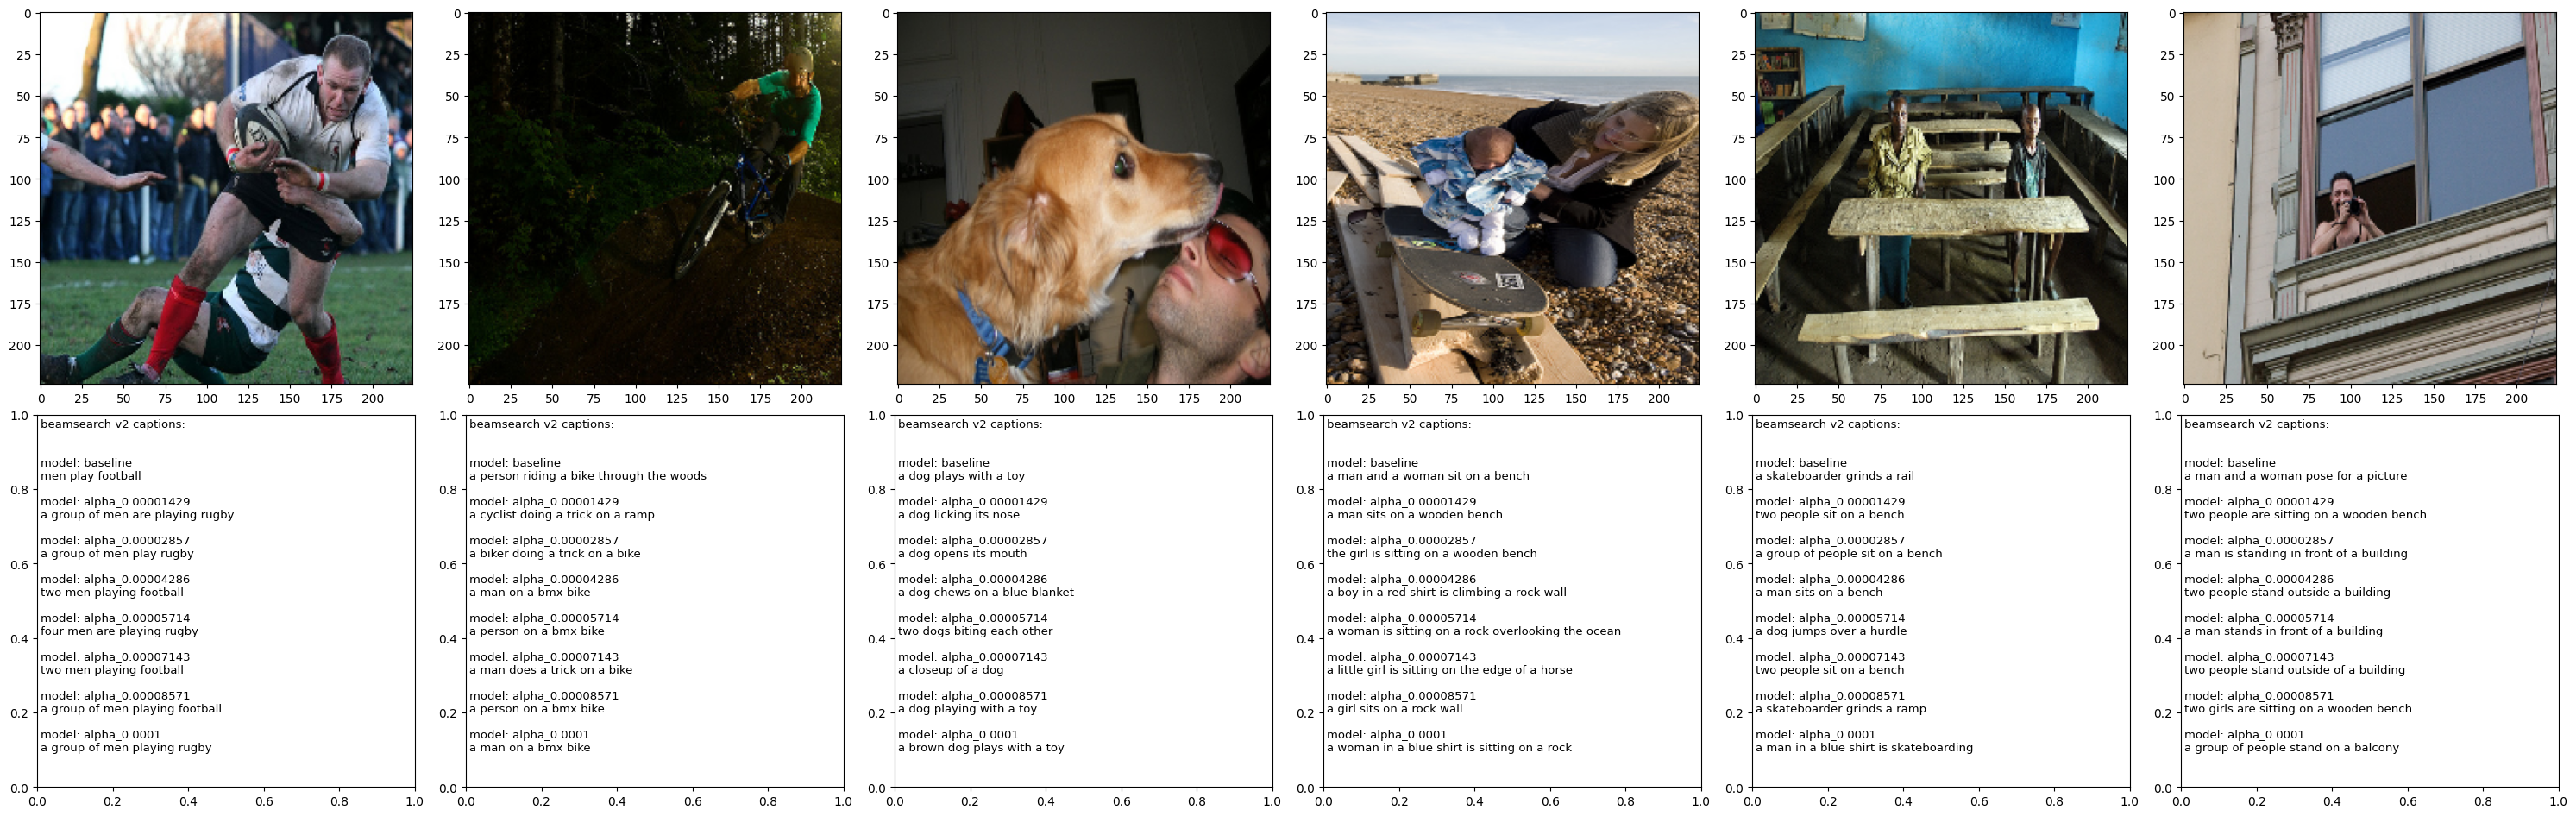

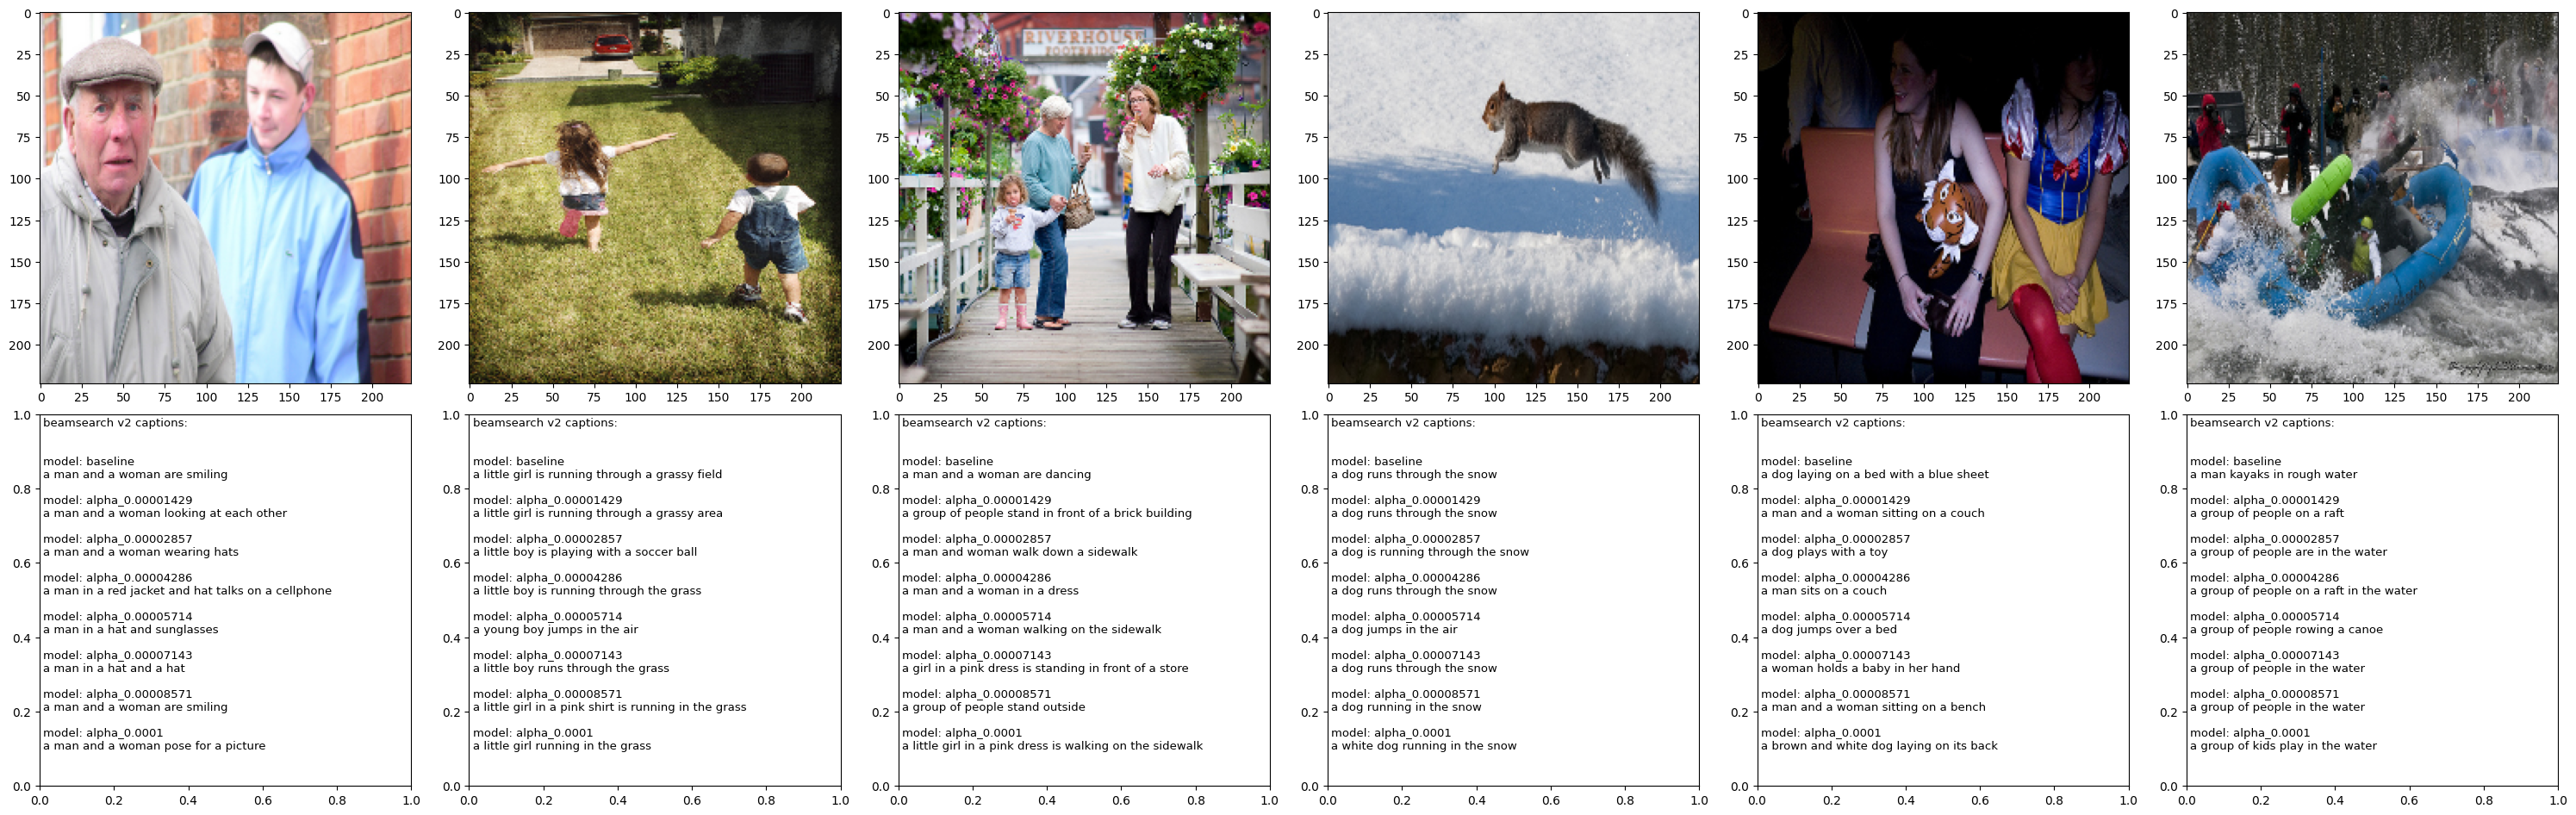

In [17]:
models = {
    "baseline": load_best_model_from_run("7q0aieim"),
    "alpha_0.00001429": load_best_model_from_run("5gn63xb8"),
    "alpha_0.00002857": load_best_model_from_run("gp0g9adr"),
    "alpha_0.00004286": load_best_model_from_run("xuukkrf8"),
    "alpha_0.00005714": load_best_model_from_run("868lldru"),
    "alpha_0.00007143": load_best_model_from_run("g535gle0"),
    "alpha_0.00008571": load_best_model_from_run("rr8v0xje"),
    "alpha_0.0001": load_best_model_from_run("ssfcsinv"),
}

plot_images_and_captions(models, seed=12345)
plot_images_and_captions(models, seed=6)

Betrachtet man nun diese Captions, so fällt auf, dass die meissten Modelle die Situationen ungefär auf den Bildern beschreiben können.

Allerdings haben alle Modelle bei spezifischen Bildern Schwierigkeiten die Details einzufangen.

Was Farben betrifft, haben alle Modelle etwas Schwierigkeiten.

### Report

In [18]:
IFrame("https://wandb.ai/t_buess/del_mc2_rev2/reports/L2-Regularization-Data-augmentation--Vmlldzo0NjU1Mzkx", "100%", "1024px")

# Conclusion

Ein LSTM ist vielseitig einsetzbar, dazu gehört *time series forecasting*, *natural language translation*, *text classification* und unter anderem auch *image captioning*.

Beim Image captioning übernimmt ein CNN die Komprimierung der Informationen aus einem Bild, welche anschliessend an ein LSTM übergeben wird.

Dieses kann nun aufgrund der Bildinformationen eine Abfolge von Wörtern (Tokens) generieren, welche das Bild am besten beschreibt. Dabei beachtet das Modell die Wörter, welche bereits Preducted wurden.

Dies stellt sicher, dass nicht einfach zufällige Wörter herausgespuckt werden, sondern ein logischen und korrekter Satz entsteht.

Um das Modell zu trainieren, wurde der Flickr8k Datensatz verwendet, welcher aus 8k verschiedenen Bildern besteht, wobei jedes Bild 5 handgeschriebene Captions besitzt.

## Tokenization

Bei der Tokenisierung der Captions wurde jeweils die Punctuation entfernt, wobei diese anschliessend in einzelne Wörter aufgesplittet wurde.

Danach wurde das Vokabular gebildet, wobei jeder Token mindestens 10 mal vorkommen muss um in dieses zu gelangen.

Dadurch erhalten wir ein Vokabular mit einer Grösse von 1958 und verlieren somit 75% des grösstmöglichen Vokabulars.

Dieser Approach wurde gewählt, weil davon ausgegangen wird, dass Tokens, welche nicht oft vorkommen, nicht viel zum Modell beitragen.

Möglicherweise war dies ein Fehler, da dadurch Löcher in die Captions gerissen werden, welche sich schlussendlich auf die Qualität der Vorhersagten Sätze auswirken kann.

Auch die Entfernung der Punctuation (wie ein Komma oder auch ein Punkt in der Mitte der Caption) kann die Qualität der Predictions beeinträchtigen.

Da auch mehrere Versionen eines Wortes (Konjugation usw) existieren kann, wäre es sicherlich auch nicht verkehrt gewesen einen Lemmatizer auf die einzelnen Wörter anzuwenden, was das Vokabular sicherlich auch auf natürliche Weise geschrumpft hätte.

## Modell

Das Modell bestehend aus dem *resnet50* als CNN und LSTM als RNN war in der Lage die Informationen der Bilder aufzunehmen, was beim Experiment mit dem Overfitting gezeigt werden konnte.

Auch die qualitativen Analysen zum späteren Zeitpunkt lassen darauf schliessen, dass das Modell auf den Trainingsdaten lernen konnte.

Beim Training wurde der negaitve log loss mittels Teacher forcing Methode berechnet. Dies garantiert eine schnelle und effiziente berechnung des Losses, da bereits die ganze Sequenz in das LSTM gegeben werden kann.

Bei der Validierung wurde der selbe approach Verwendet. Dies ist nicht ganz vorteilhaft, da ein Modell normalerweise die korrekte caption nicht kennt. Allerdings gehe ich davon aus, dass so trotzdem ein Overfitting erkannt und vermiden werden kann.

Des weiteren wurden alle Entscheidungen getroffen, ohne eine Fehlerabschätzung gemacht zu haben (cross validation).

Ich habe mich allerdings gegen eine solche Entschieden, da ansonnsten tagelang trainiert hätte werden müssen.

## Effekt des Embedding-size

Beim variieren der Grösse der Embeddings war auffällig, dass das Modell bei kleineren Embedding-sizes rein qualitativ nicht deutlich schlechtere Predictions produzierten wie die Modelle mit grösseren Embeddings.

Möglicherweise hängt dies auch von der Verteilung der Bilder ab, sowie von der Grösse des Vokabulars.

Um zu sehen, auf welche Einzelheiten das Modell bei den Bildern achtet, wäre eine Activation Map sicherlich auch interessant gewesen.

## Effekt der Hidden-size

Beim variieren der Grösse der Hidden-size war auffällig, dass eine kleine Grösse zu deutlich schlechteren Predictions geführt hat.

Möglicherweise war das LSTM nicht mehr in der Lage die Informationen des Bildes über die dauer der Prediction zu speichern oder schon überhaupt aufzunehmen.

## Tuning der Embedding/Hidden-size mit *resnet50* als CNN:

Beim Variieren der Grösse, wurde qualitativ kein bemerkbarer Qualitätsunterschied zwischen den Modellen bemerkt.

Betrachtet man Validierungs-loss, so konnte das beste Modell mit einer Grösse von 768 identifiziert werden.

Des weiteren wurde die Embedding sowie Hidden-size auf das gleiche Value gesetzt, was auch nicht ideal ist.

Man hätte mittels gridseach beide Hyperparameter separat tunen können.

## Tuning der Embedding/Hidden-size mit *densenet201* als CNN:

Beim Variieren der Grösse, konnte festgestellt werden, dass das Modell mit der Grösse von 1792 laut Validierungs-loss am besten performt.

Vergleicht man allerdings das beste Modell mit *resnet50* als CNN mit dem besten mit *densenet201* als CNN, so konnte das Densenet-Modell das Resnet-Modell nicht outperformen.

## Data augmentation & Regularization

Um künstlich mehr Trainingsdaten zu erzeugen, wurde eine Data-augmentation auf den Trainingsdaten durchgeführt, in der Hoffnung, dass das Modell so weniger gut overfitten kann und besser generalisiert.

Dies hat sich auch bewahrheitet.

Anschliessend wurde auf einem zu flexiblen Modell (welches schnell overfittet) neben der Data-augmentation auch noch ein weight-decay eingeführt, welches verhindern soll, dass die Weights zu stark wachsen.

Nach dem optimieren, konnte qualitativ sowie auch im Validation-loss eine Verbesserung gegenüber dem besten Modell des Data-augmentation-only Experiments festgestellt werden.

In [ ]:
#custom image
root = tkinter.Tk()
root.withdraw()
file_path = tkinter.filedialog.askopenfilename()
root.destroy()

image = Image.open(file_path)
image = transform(image)

imshow(image)

max_num_words = 30
print("greedy caption: ", model.sample_greedy(image.cuda(), max_num_words=max_num_words))
print("beamsearch caption: ", model.sample_beamSearch(image.cuda(), max_num_words=max_num_words, beam_size=10))
print("beamsearch caption (v2): ", model.sample_beamSearch_v2(image.cuda(), max_num_words=max_num_words, beam_size=10))